In [1]:

# # Vaccines and patient characteristics

In [2]:





# ### Import libraries and data
# 
# The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [3]:


get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import subprocess
from IPython.display import display, Markdown, HTML
import os


suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()


# ### Import our custom functions

In [4]:


# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [5]:


from data_processing import load_data
from second_third_doses import abbreviate_time_period


In [6]:


from report_results import find_and_save_latest_date, create_output_dirs, report_results, round7

In [7]:


# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()


# ### Load and Process the raw data 

In [8]:


df = load_data( save_path = savepath )

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/data_processing.py:153: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(["imd","ethnicity_16", "ethnicity", 'ethnicity_6_sus',
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/data_processing.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['care_home', 'age'], 1)


In [9]:


latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [10]:


print(f"Latest Date: {formatted_latest_date}")


# ### Summarise by group and demographics at latest date

# #### Calculate cumulative sums at each date and select latest date + previous figures for comparison

Latest Date: 02 Feb 2022


In [11]:


from report_results import cumulative_sums

In [12]:


# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "40-49": 10,
        "30-39": 11,
        "18-29": 12,                
        "16-17": 0 
        # NB if the population denominator is not included for the final group (0), the key must contain phrase "not in other eligible groups" so that data is presented appropriately
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "housebound", "chronic_cardiac_disease", "current_copd", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "ckd"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "housebound")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "housebound"
                                      )]
o40 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "housebound"
                                       )]
# under50s
u40 = ["sex", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    u40, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD", "ckd"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "40-49":    o40,
                 "30-39":    u40,
                 "18-29":    u40,
                 "16-17":    ["sex", "ethnicity_6_groups", "imd_categories"],
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }

In [13]:


df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)


In [14]:


# for details on second/third doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

df_dict_cum_third_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")


# ### Cumulative vaccination figures - overall

In [15]:


from report_results import make_vaccine_graphs

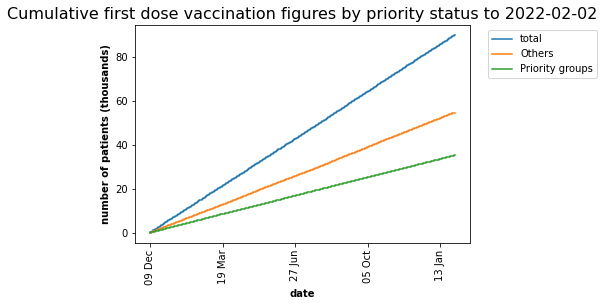

In [16]:


make_vaccine_graphs(df, latest_date=latest_date, grouping="priority_status", savepath_figure_csvs=savepath_figure_csvs, savepath=savepath, suffix=suffix)

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:311: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfp = dfp.drop("total", 1)


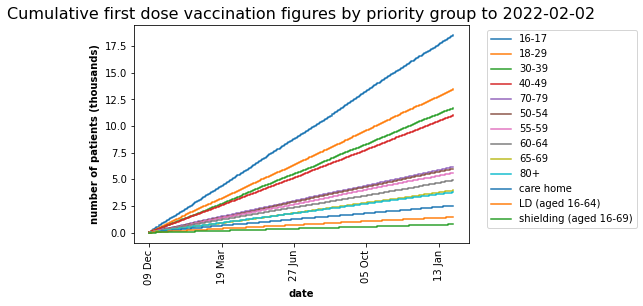

In [17]:


make_vaccine_graphs(df, latest_date=latest_date, include_total=False, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)


# ### Reports 

In [18]:


from report_results import summarise_data_by_group

In [19]:


summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_date].reset_index().set_index(reference_column_name).drop(["index"], 1).transpose()
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:440: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' wi

In [20]:


summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

summarised_data_dict_3rd_dose = summarise_data_by_group(df_dict_cum_third_dose, latest_date=latest_date, groups=groups)


# ### Proportion of each eligible population vaccinated to date

In [21]:


from report_results import create_summary_stats, create_detailed_summary_uptake

In [22]:


summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [23]:


summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

summ_stat_results_3rd_dose, _ = create_summary_stats(df, summarised_data_dict_3rd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="third_dose", suffix=suffix)

In [24]:


# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)).join(pd.DataFrame(summ_stat_results_3rd_dose)))   
display(Markdown(f"*\n figures rounded to nearest 7"))

first dose as at 02 Feb 2022  \
Total vaccinated in TPP                       89,999   
80+                           89.9% (3,794 of 4,221)   
70-79                         90.2% (6,188 of 6,860)   
care home                     89.8% (2,534 of 2,821)   
shielding (aged 16-69)            89.5% (777 of 868)   
65-69                         90.0% (3,976 of 4,417)   
LD (aged 16-64)               91.3% (1,463 of 1,603)   
60-64                         90.4% (4,928 of 5,453)   
55-59                         90.3% (5,621 of 6,223)   
50-54                         89.4% (6,013 of 6,727)   
40-49                       89.9% (11,018 of 12,257)   
30-39                       90.3% (11,704 of 12,957)   
18-29                       89.8% (13,440 of 14,966)   
16-17                       89.9% (18,550 of 20,636)   

                        second dose as at 02 Feb 2022  \
Total vaccinated in TPP                        80,003   
80+                            79.9% (3,374 of 4,221)   
70-79                          79.2% (5,432 of 6,860)   
care home                      79.2% (2,233 of 2,821)   
shielding (aged 16-69)             83.1% (721 of 868)   
65-69                          80.3% (3,549 of 4,417)   
LD (aged 16-64)                80.8% (1,295 of 1,603)   
60-64                          79.6% (4,340 of 5,453)   
55-59                          80.2% (4,991 of 6,223)   
50-54                          79.3% (5,334 of 6,727)   
40-49                         80.5% (9,863 of 12,257)   
30-39                        80.4% (10,416 of 12,957)   
18-29                        80.3% (12,019 of 14,966)   
16-17                        79.6% (16,436 of 20,636)   

                        third dose as at 02 Feb 2022  
Total vaccinated in TPP                       10,003  
80+                             10.1% (427 of 4,221)  
70-79                           10.1% (693 of 6,860)  
care home                        9.4% (266 of 2,821)  
shielding (aged 16-69)             10.5% (91 of 868)  
65-69                           10.3% (455 of 4,417)  
LD (aged 16-64)                  9.2% (147 of 1,603)  
60-64                           10.1% (553 of 5,453)  
55-59                            9.6% (595 of 6,223)  
50-54                           10.0% (672 of 6,727)  
40-49                         9.9% (1,211 of 12,257)  
30-39                         9.6% (1,239 of 12,957)  
18-29                        10.2% (1,526 of 14,966)  
16-17                        10.3% (2,135 of 20,636)

*
 figures rounded to nearest 7

In [25]:


# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))


# # Detailed summary of coverage among population groups as at latest date

Oxford-AZ vaccines (% of all first doses): **0.1%** (77)

Pfizer vaccines (% of all first doses): **0.2%** (140)

Moderna vaccines (% of all first doses): **0.1%** (49)

Second doses (% of all vaccinated): **88.9%** (80,003)

Second doses (% of Ox-AZ first doses): **6190.9%** (4,767)

Second doses (% of Pfizer first doses): **1765.0%** (2,471)

Second doses (% of Moderna first doses): **12257.1%** (6,006)

Mixed doses Ox-AZ + Pfizer (% of fully vaccinated): **0.0%** (0)

Mixed doses Ox-AZ + Moderna (% of fully vaccinated): **0.0%** (0)

Mixed doses Moderna + Pfizer (% of fully vaccinated): **0.0%** (0)

*
 figures rounded to nearest 7

In [26]:


create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)


# # Demographics time trend charts

## 

## COVID vaccination rollout (first dose) among **80+** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3794   
sex                       F                                          1960   
                          M                                          1834   
ageband_5yr               0                                            56   
                          0-15                                        231   
                          16-17                                       217   
                          18-29                                       245   
                          30-34                                       245   
                          35-39                                       238   
                          40-44                                       252   
                          45-49                                       259   
                          50-54                                       238   
                          55-59                                       280   
                          60-64                                       238   
                          65-69                                       245   
                          70-74                                       266   
                          75-79                                       252   
                          80-84                                       252   
                          85-89                                       252   
                          90+                                          28   
ethnicity_6_groups        Black                                       644   
                          Mixed                                       630   
                          Other                                       658   
                          South Asian                                 672   
                          Unknown                                     553   
                          White                                       644   
ethnicity_16_groups        African                                    203   
                           Bangladeshi or British Bangladeshi         175   
                           Caribbean                                  196   
                           Chinese                                    189   
                           Other                                      210   
                           Other Asian                                196   
                          British or Mixed British                    196   
                          Indian or British Indian                    196   
                          Irish                                       210   
                          Other Black                                 196   
                          Other White                                 210   
                          Other mixed                                 189   
                          Pakistani or British Pakistani              203   
                          Unknown                                     602   
                          White + Asian                               196   
                          White + Black African                       196   
                          White + Black Caribbean                     224   
imd_categories            1 Most deprived                             721   
                          2                                           735   
                          3                                           693   
                          4                                           735   
                          5 Least deprived                            728   
                          Unknown                                     189   
bmi                       30+                                        1169   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **70-79** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    6188   
sex                       F                                          3220   
                          M                                          2968   
ageband_5yr               0                                            77   
                          0-15                                        392   
                          16-17                                       406   
                          18-29                                       392   
                          30-34                                       420   
                          35-39                                       413   
                          40-44                                       385   
                          45-49                                       406   
                          50-54                                       406   
                          55-59                                       406   
                          60-64                                       406   
                          65-69                                       399   
                          70-74                                       392   
                          75-79                                       406   
                          80-84                                       392   
                          85-89                                       413   
                          90+                                          70   
ethnicity_6_groups        Black                                      1050   
                          Mixed                                      1071   
                          Other                                      1057   
                          South Asian                                1078   
                          Unknown                                     924   
                          White                                      1001   
ethnicity_16_groups        African                                    329   
                           Bangladeshi or British Bangladeshi         315   
                           Caribbean                                  343   
                           Chinese                                    322   
                           Other                                      329   
                           Other Asian                                336   
                          British or Mixed British                    308   
                          Indian or British Indian                    336   
                          Irish                                       329   
                          Other Black                                 329   
                          Other White                                 329   
                          Other mixed                                 315   
                          Pakistani or British Pakistani              294   
                          Unknown                                     917   
                          White + Asian                               350   
                          White + Black African                       350   
                          White + Black Caribbean                     357   
imd_categories            1 Most deprived                            1169   
                          2                                          1218   
                          3                                          1162   
                          4                                          1190   
                          5 Least deprived                           1148   
                          Unknown                                     301   
bmi                       30+                                        1855   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **care home** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            2534     89.8   2821   
sex                F                  1274     89.2   1428   
                   M                  1260     90.9   1386   
ageband_5yr        0                    28    100.0     28   
                   0-15                161     92.0    175   
                   16-17               175     89.3    196   
                   18-29               154     91.7    168   
                   30-34               175     92.6    189   
                   35-39               161     85.2    189   
                   40-44               140     83.3    168   
                   45-49               161     88.5    182   
                   50-54               168     92.3    182   
                   55-59               175     89.3    196   
                   60-64               182     92.9    196   
                   65-69               161     88.5    182   
                   70-74               168     88.9    189   
                   75-79               154     88.0    175   
                   80-84               161     88.5    182   
                   85-89               161     92.0    175   
                   90+                  49    100.0     49   
ethnicity_6_groups Black               399     89.1    448   
                   Mixed               427     92.4    462   
                   Other               455     90.3    504   
                   South Asian         434     92.5    469   
                   Unknown             392     90.3    434   
                   White               434     88.6    490   
dementia           no                 2513     90.0   2793   
                   yes                  28    100.0     28   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 88.3   
sex                F                                       87.7   
                   M                                       89.4   
ageband_5yr        0                                       75.0   
                   0-15                                    92.0   
                   16-17                                   85.7   
                   18-29                                   91.7   
                   30-34                                   88.9   
                   35-39                                   85.2   
                   40-44                                   83.3   
                   45-49                                   88.5   
                   50-54                                   88.5   
                   55-59                                   89.3   
                   60-64                                   89.3   
                   65-69                                   88.5   
                   70-74                                   88.9   
                   75-79                                   84.0   
                   80-84                                   88.5   
                   85-89                                   92.0   
                   90+                                    100.0   
ethnicity_6_groups Black                                   85.9   
                   Mixed                                   90.9   
                   Other                                   88.9   
                   South Asian                             89.6   
                   Unknown                                 88.7   
                   White                                   87.1   
dementia           no                                      88.2   
                   yes                                    100.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **shielding (aged 16-69)** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  777     89.5    868   
newly_shielded_since_feb_15 no                       770     89.4    861   
                            yes                        7    100.0      7   
sex                         F                        406     90.6    448   
                            M                        371     88.3    420   
ageband                     16-29                     98     93.3    105   
                            30-39                     91     86.7    105   
                            40-49                     98     87.5    112   
                            50-59                    105     83.3    126   
                            60-69                     98     87.5    112   
                            70-79                    182     89.7    203   
                            80+                      105     93.8    112   
ethnicity_6_groups          Black                    126     90.0    140   
                            Mixed                    147     91.3    161   
                            Other                    126     90.0    140   
                            South Asian              126     85.7    147   
                            Unknown                  105     88.2    119   
                            White                    147     91.3    161   
imd_categories              1 Most deprived          161     88.5    182   
                            2                        126     85.7    147   
                            3                        147     87.5    168   
                            4                        147     91.3    161   
                            5 Least deprived         154     91.7    168   
                            Unknown                   35     83.3     42   
LD                          no                       763     89.3    854   
                            yes                       14    100.0     14   
ckd                         no                       644     89.3    721   
                            yes                      133     90.5    147   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      88.7   
newly_shielded_since_feb_15 no                                           87.8   
                            yes                                         100.0   
sex                         F                                            89.1   
                            M                                            88.3   
ageband                     16-29                                        86.7   
                            30-39                                        86.7   
                            40-49                                        87.5   
                            50-59                                        83.3   
                            60-69                                        81.2   
                            70-79                                        89.7   
                            80+                                          93.8   
ethnicity_6_groups          Black                                        90.0   
                            Mixed                                        87.0   
                            Other                                        90.0   
                            South Asian                                  85.7   
                            Unknown                                      88.2   
                            White                                        91.3   
imd_categories              1 Most deprived                              84.6   
                            2                                   

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **65-69** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3976   
sex                       F                                          1995   
                          M                                          1974   
ethnicity_6_groups        Black                                       672   
                          Mixed                                       693   
                          Other                                       665   
                          South Asian                                 637   
                          Unknown                                     637   
                          White                                       672   
ethnicity_16_groups        African                                    210   
                           Bangladeshi or British Bangladeshi         210   
                           Caribbean                                  217   
                           Chinese                                    210   
                           Other                                      245   
                           Other Asian                                196   
                          British or Mixed British                    224   
                          Indian or British Indian                    224   
                          Irish                                       210   
                          Other Black                                 217   
                          Other White                                 210   
                          Other mixed                                 217   
                          Pakistani or British Pakistani              217   
                          Unknown                                     560   
                          White + Asian                               203   
                          White + Black African                       182   
                          White + Black Caribbean                     231   
imd_categories            1 Most deprived                             735   
                          2                                           749   
                          3                                           777   
                          4                                           749   
                          5 Least deprived                            763   
                          Unknown                                     210   
bmi                       30+                                        1246   
                          under 30                                   2723   
housebound                no                                         3927   
                          yes                                          49   
chronic_cardiac_disease   no                                         3934   
                          yes                                          42   
current_copd              no                                         3941   
                          yes                                          35   
dmards                    no                                         3934   
                          yes                                          42   
dementia                  no                                         3934   
                          yes                                          42   
psychosis_schiz_bipolar   no                                         3934   
                          yes                                          42   
LD                        no                                         3885   
                          yes                                          91   
ssri                      no                                         3941   
                          yes                                          28   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **LD (aged 16-64)** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1463     91.3   1603   
sex                F                   721     91.2    791   
                   M                   742     91.4    812   
ageband_5yr        0                    21    100.0     21   
                   0-15                 98     93.3    105   
                   16-17               105     93.8    112   
                   18-29                98     93.3    105   
                   30-34                84     85.7     98   
                   35-39                98     93.3    105   
                   40-44                77     91.7     84   
                   45-49               105     88.2    119   
                   50-54               119     89.5    133   
                   55-59                98     93.3    105   
                   60-64                91     92.9     98   
                   65-69                91     92.9     98   
                   70-74                84     92.3     91   
                   75-79                98     93.3    105   
                   80-84                84     85.7     98   
                   85-89                98     93.3    105   
                   90+                  14    100.0     14   
ethnicity_6_groups Black               252     92.3    273   
                   Mixed               259     92.5    280   
                   Other               266     90.5    294   
                   South Asian         245     89.7    273   
                   Unknown             203     90.6    224   
                   White               238     91.9    259   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 89.5   
sex                F                                       89.4   
                   M                                       89.7   
ageband_5yr        0                                       66.7   
                   0-15                                    93.3   
                   16-17                                   93.8   
                   18-29                                   86.7   
                   30-34                                   85.7   
                   35-39                                   93.3   
                   40-44                                   91.7   
                   45-49                                   88.2   
                   50-54                                   89.5   
                   55-59                                   93.3   
                   60-64                                   85.7   
                   65-69                                   85.7   
                   70-74                                   84.6   
                   75-79                                   93.3   
                   80-84                                   85.7   
                   85-89                                   93.3   
                   90+                                    100.0   
ethnicity_6_groups Black                                   89.7   
                   Mixed                                   90.0   
                   Other                                   88.1   
                   South Asian                             87.2   
                   Unknown                                 90.6   
                   White                                   89.2   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.8   
sex                F                                     1.8   
                   M                                     1.7   
ageband_5yr        0                                    33.3   
                   0-15           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **60-64** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    4928   
sex                       F                                          2534   
                          M                                          2394   
ethnicity_6_groups        Black                                       861   
                          Mixed                                       854   
                          Other                                       805   
                          South Asian                                 812   
                          Unknown                                     742   
                          White                                       854   
ethnicity_16_groups        African                                    259   
                           Bangladeshi or British Bangladeshi         266   
                           Caribbean                                  280   
                           Chinese                                    266   
                           Other                                      273   
                           Other Asian                                266   
                          British or Mixed British                    231   
                          Indian or British Indian                    245   
                          Irish                                       245   
                          Other Black                                 259   
                          Other White                                 252   
                          Other mixed                                 238   
                          Pakistani or British Pakistani              287   
                          Unknown                                     735   
                          White + Asian                               266   
                          White + Black African                       280   
                          White + Black Caribbean                     287   
imd_categories            1 Most deprived                             903   
                          2                                           938   
                          3                                           973   
                          4                                           910   
                          5 Least deprived                            952   
                          Unknown                                     252   
bmi                       30+                                        1477   
                          under 30                                   3451   
chronic_cardiac_disease   no                                         4886   
                          yes                                          42   
current_copd              no                                         4872   
                          yes                                          56   
dmards                    no                                         4872   
                          yes                                          56   
dementia                  no                                         4858   
                          yes                                          70   
psychosis_schiz_bipolar   no                                         4879   
                          yes                                          49   
ssri                      no                                         4879   
                          yes                                          42   
chemo_or_radio            no                                         4872   
                          yes                                          56   
lung_cancer               no                                         4886   
                          yes                                          42   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **55-59** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    5621   
sex                     F                                          2891   
                        M                                          2730   
ethnicity_6_groups      Black                                       938   
                        Mixed                                       959   
                        Other                                       994   
                        South Asian                                 910   
                        Unknown                                     861   
                        White                                       966   
ethnicity_16_groups      African                                    280   
                         Bangladeshi or British Bangladeshi         280   
                         Caribbean                                  294   
                         Chinese                                    259   
                         Other                                      294   
                         Other Asian                                273   
                        British or Mixed British                    315   
                        Indian or British Indian                    287   
                        Irish                                       301   
                        Other Black                                 315   
                        Other White                                 315   
                        Other mixed                                 287   
                        Pakistani or British Pakistani              322   
                        Unknown                                     854   
                        White + Asian                               294   
                        White + Black African                       336   
                        White + Black Caribbean                     301   
imd_categories          1 Most deprived                            1099   
                        2                                          1029   
                        3                                          1099   
                        4                                          1085   
                        5 Least deprived                           1029   
                        Unknown                                     287   
bmi                     30+                                        1652   
                        under 30                                   3969   
chronic_cardiac_disease no                                         5551   
                        yes                                          70   
current_copd            no                                         5579   
                        yes                                          42   
dmards                  no                                         5558   
                        yes                                          63   
psychosis_schiz_bipolar no                                         5565   
                        yes                                          56   
ssri                    no                                         5558   
                        yes                                          63   
ckd                     no                                         4452   
                        yes                                        1169   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 90.3   6223   
sex                     F                                       90.2   3206   
                        M                                       90.5   3017   
ethnicity_6_groups      Black                                   9

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **50-54** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    6013   
sex                     F                                          3038   
                        M                                          2975   
ethnicity_6_groups      Black                                      1099   
                        Mixed                                      1043   
                        Other                                      1001   
                        South Asian                                 959   
                        Unknown                                     875   
                        White                                      1029   
ethnicity_16_groups      African                                    329   
                         Bangladeshi or British Bangladeshi         315   
                         Caribbean                                  315   
                         Chinese                                    315   
                         Other                                      315   
                         Other Asian                                336   
                        British or Mixed British                    301   
                        Indian or British Indian                    357   
                        Irish                                       308   
                        Other Black                                 336   
                        Other White                                 308   
                        Other mixed                                 308   
                        Pakistani or British Pakistani              329   
                        Unknown                                     910   
                        White + Asian                               315   
                        White + Black African                       308   
                        White + Black Caribbean                     322   
imd_categories          1 Most deprived                            1134   
                        2                                          1169   
                        3                                          1113   
                        4                                          1141   
                        5 Least deprived                           1120   
                        Unknown                                     343   
bmi                     30+                                        1743   
                        under 30                                   4270   
chronic_cardiac_disease no                                         5950   
                        yes                                          56   
current_copd            no                                         5943   
                        yes                                          70   
dmards                  no                                         5964   
                        yes                                          49   
psychosis_schiz_bipolar no                                         5957   
                        yes                                          56   
ssri                    no                                         5950   
                        yes                                          56   
ckd                     no                                         4788   
                        yes                                        1225   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 89.4   6727   
sex                     F                                       89.3   3402   
                        M                                       89.5   3325   
ethnicity_6_groups      Black                                   9

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **40-49** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                   11018   
sex                     F                                          5733   
                        M                                          5285   
ethnicity_6_groups      Black                                      1869   
                        Mixed                                      1883   
                        Other                                      1827   
                        South Asian                                1862   
                        Unknown                                    1722   
                        White                                      1855   
ethnicity_16_groups      African                                    567   
                         Bangladeshi or British Bangladeshi         574   
                         Caribbean                                  637   
                         Chinese                                    581   
                         Other                                      616   
                         Other Asian                                560   
                        British or Mixed British                    567   
                        Indian or British Indian                    581   
                        Irish                                       616   
                        Other Black                                 609   
                        Other White                                 623   
                        Other mixed                                 567   
                        Pakistani or British Pakistani              546   
                        Unknown                                    1638   
                        White + Asian                               546   
                        White + Black African                       581   
                        White + Black Caribbean                     602   
imd_categories          1 Most deprived                            2079   
                        2                                          2072   
                        3                                          2093   
                        4                                          2093   
                        5 Least deprived                           2114   
                        Unknown                                     560   
bmi                     30+                                        3318   
                        under 30                                   7700   
chronic_cardiac_disease no                                        10892   
                        yes                                         126   
current_copd            no                                        10913   
                        yes                                         105   
dmards                  no                                        10892   
                        yes                                         126   
psychosis_schiz_bipolar no                                        10913   
                        yes                                         105   
ssri                    no                                        10934   
                        yes                                          84   
ckd                     no                                         8841   
                        yes                                        2177   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 89.9  12257   
sex                     F                                       89.7   6391   
                        M                                       90.1   5866   
ethnicity_6_groups      Black                                   8

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **30-39** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                   11704     90.3   
sex                 F                                          6090     90.5   
                    M                                          5607     90.0   
ethnicity_6_groups  Black                                      2002     89.7   
                    Mixed                                      1988     90.2   
                    Other                                      1932     90.8   
                    South Asian                                2030     90.1   
                    Unknown                                    1736     90.5   
                    White                                      2009     90.3   
ethnicity_16_groups  African                                    644     92.0   
                     Bangladeshi or British Bangladeshi         616     89.8   
                     Caribbean                                  588     89.4   
                     Chinese                                    623     89.0   
                     Other                                      609     89.7   
                     Other Asian                                651     91.2   
                    British or Mixed British                    637     89.2   
                    Indian or British Indian                    623     90.8   
                    Irish                                       581     90.2   
                    Other Black                                 623     89.9   
                    Other White                                 588     89.4   
                    Other mixed                                 630     90.9   
                    Pakistani or British Pakistani              658     89.5   
                    Unknown                                    1750     91.6   
                    White + Asian                               630     90.9   
                    White + Black African                       651     90.3   
                    White + Black Caribbean                     602     90.5   
imd_categories      1 Most deprived                            2240     90.7   
                    2                                          2247     90.7   
                    3                                          2198     89.7   
                    4                                          2219     90.6   
                    5 Least deprived                           2205     90.5   
                    Unknown                                     588     87.5   

                                                         total  \
category            group                                        
overall             overall                              12957   
sex                 F                                     6727   
                    M                                     6230   
ethnicity_6_groups  Black                                 2233   
                    Mixed                                 2205   
                    Other                                 2128   
                    South Asian                           2254   
                    Unknown                               1918   
                    White                                 2226   
ethnicity_16_groups  African                               700   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             658   
                     Chinese                               700   
                     Other                                 679   
                     Other Asian                           714   
                    British or Mixed British               714   
                    Indian or British Indian               686   
                    Irish                                  644   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **18-29** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                   13440     89.8   
sex                 F                                          6909     89.9   
                    M                                          6531     89.6   
ethnicity_6_groups  Black                                      2317     90.7   
                    Mixed                                      2310     89.7   
                    Other                                      2296     89.6   
                    South Asian                                2247     89.4   
                    Unknown                                    2023     90.6   
                    White                                      2254     89.4   
ethnicity_16_groups  African                                    721     92.0   
                     Bangladeshi or British Bangladeshi         721     89.6   
                     Caribbean                                  714     91.1   
                     Chinese                                    721     88.8   
                     Other                                      728     91.2   
                     Other Asian                                700     89.3   
                    British or Mixed British                    693     90.8   
                    Indian or British Indian                    742     89.8   
                    Irish                                       700     90.9   
                    Other Black                                 714     89.5   
                    Other White                                 707     89.4   
                    Other mixed                                 707     89.4   
                    Pakistani or British Pakistani              686     89.9   
                    Unknown                                    2037     89.5   
                    White + Asian                               735     89.0   
                    White + Black African                       707     87.8   
                    White + Black Caribbean                     714     90.3   
imd_categories      1 Most deprived                            2618     89.0   
                    2                                          2555     90.1   
                    3                                          2527     88.9   
                    4                                          2583     90.4   
                    5 Least deprived                           2513     90.4   
                    Unknown                                     644     89.3   

                                                         total  \
category            group                                        
overall             overall                              14966   
sex                 F                                     7686   
                    M                                     7287   
ethnicity_6_groups  Black                                 2555   
                    Mixed                                 2576   
                    Other                                 2562   
                    South Asian                           2513   
                    Unknown                               2233   
                    White                                 2520   
ethnicity_16_groups  African                               784   
                     Bangladeshi or British Bangladeshi    805   
                     Caribbean                             784   
                     Chinese                               812   
                     Other                                 798   
                     Other Asian                           784   
                    British or Mixed British               763   
                    Indian or British Indian               826   
                    Irish                                  770   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **16-17** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                          
overall            overall                18550     89.9  20636   
sex                F                       9457     89.9  10514   
                   M                       9093     89.9  10115   
ethnicity_6_groups Black                   3150     90.0   3500   
                   Mixed                   3199     90.1   3549   
                   Other                   3171     89.9   3528   
                   South Asian             3192     89.9   3549   
                   Unknown                 2737     90.3   3031   
                   White                   3108     89.5   3472   
imd_categories     1 Most deprived         3570     89.8   3976   
                   2                       3486     89.7   3885   
                   3                       3542     90.0   3934   
                   4                       3528     89.8   3927   
                   5 Least deprived        3493     90.2   3871   
                   Unknown                  938     89.3   1050   

                                    vaccinated 7d previous (percent)  \
category           group                                               
overall            overall                                      88.4   
sex                F                                            88.4   
                   M                                            88.5   
ethnicity_6_groups Black                                        88.6   
                   Mixed                                        88.4   
                   Other                                        88.3   
                   South Asian                                  88.6   
                   Unknown                                      89.1   
                   White                                        87.9   
imd_categories     1 Most deprived                              88.6   
                   2                                            87.9   
                   3                                            88.6   
                   4                                            88.4   
                   5 Least deprived                             88.8   
                   Unknown                                      88.0   

                                    Uptake over last 7d (percent)  \
category           group                                            
overall            overall                                    1.5   
sex                F                                          1.5   
                   M                                          1.4   
ethnicity_6_groups Black                                      1.4   
                   Mixed                                      1.7   
                   Other                                      1.6   
                   South Asian                                1.3   
                   Unknown                                    1.2   
                   White                                      1.6   
imd_categories     1 Most deprived                            1.2   
                   2                                          1.8   
                   3                                          1.4   
                   4                                          1.4   
                   5 Least deprived                           1.4   
                   Unknown                                    1.3   

                                    Date projected to reach 90%  
category           group                                         
overall            overall                               02-Feb  
sex                F                                     02-Feb  
                   M                                     02-Feb  
ethnicity_6_groups Black                                reached  
                   Mixed                                reached  
                   Other            

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


In [27]:


from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **sex**

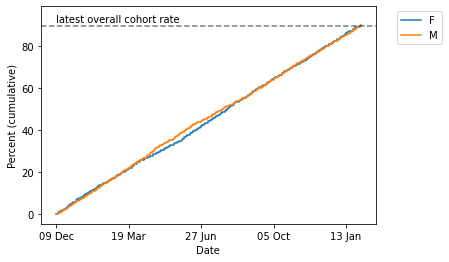

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **ageband 5yr**

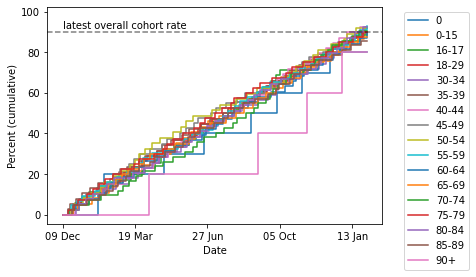

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **ethnicity 6 groups**

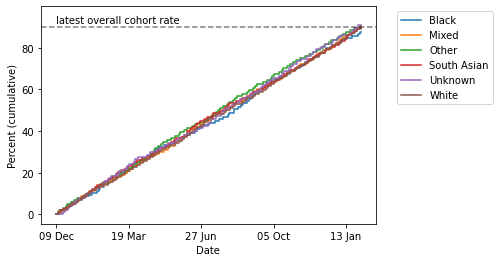

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **imd categories**

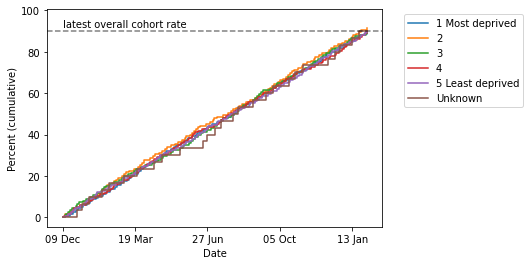

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **bmi**

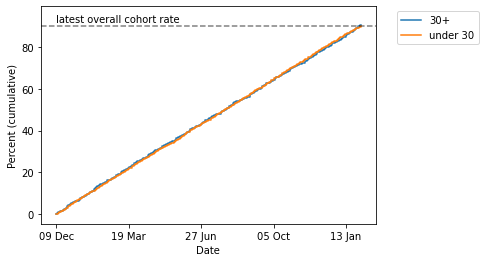

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **housebound**

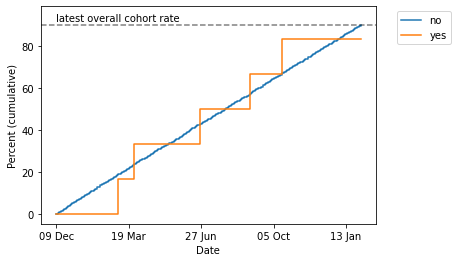

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **dementia**

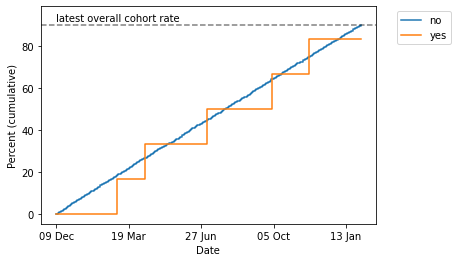

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

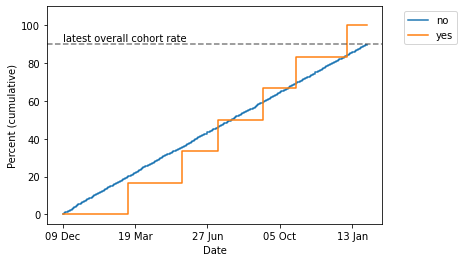

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **LD**

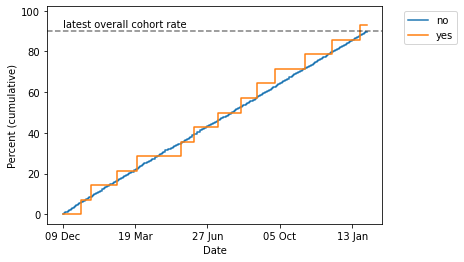

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **ssri**

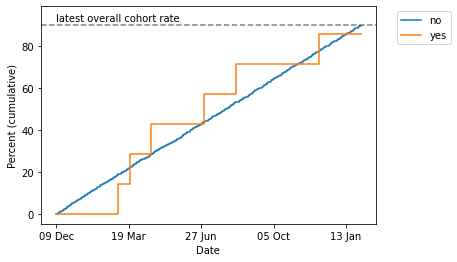

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **ckd**

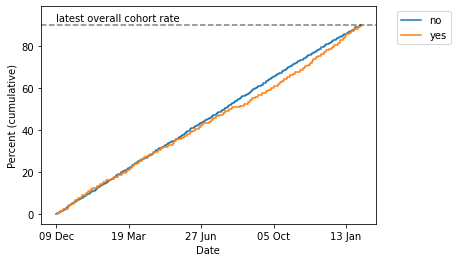

## 
 ## COVID vaccination rollout among **70-79** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **sex**

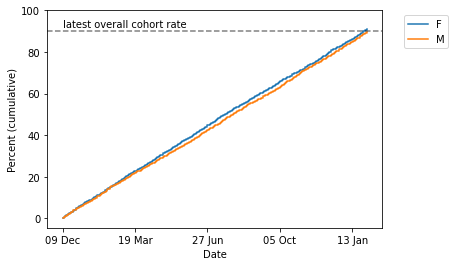

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **ageband 5yr**

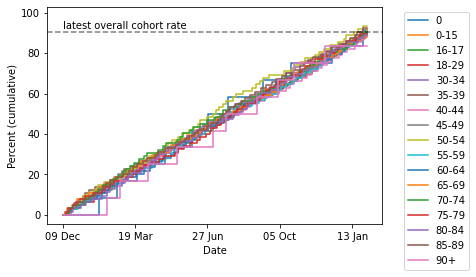

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

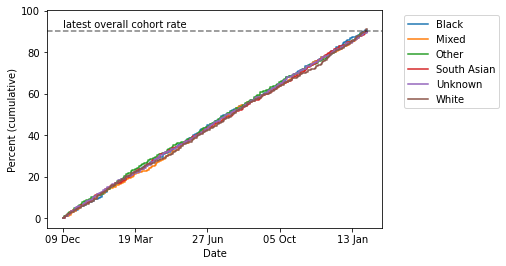

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **imd categories**

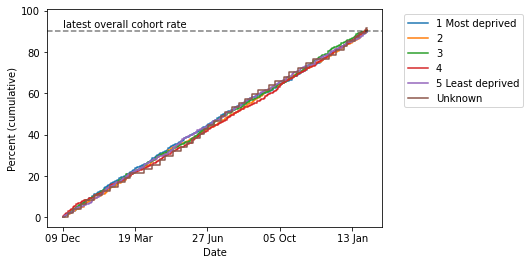

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **bmi**

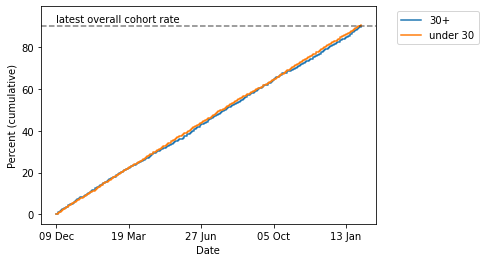

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **housebound**

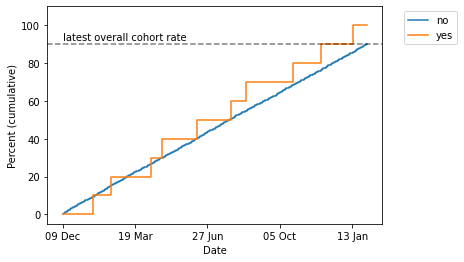

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **dementia**

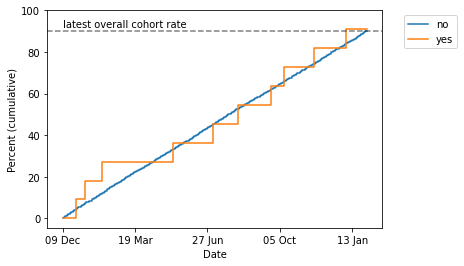

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

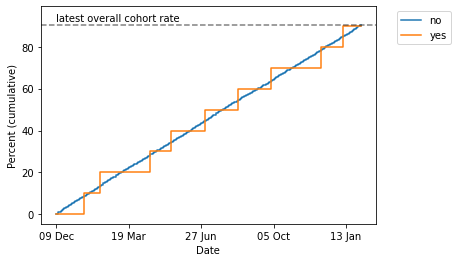

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **LD**

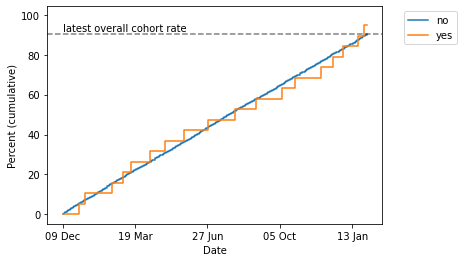

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **ssri**

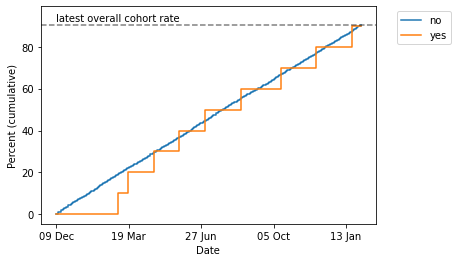

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **ckd**

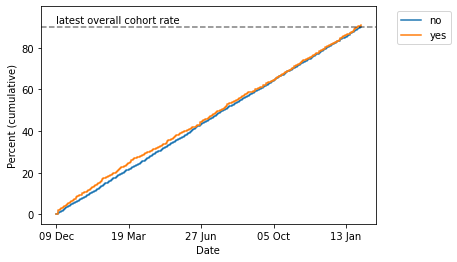

## 
 ## COVID vaccination rollout among **65-69** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **sex**

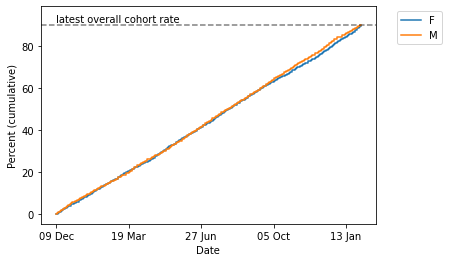

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

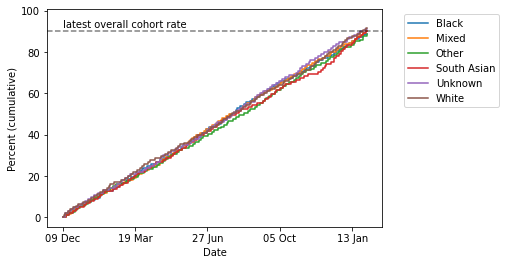

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **imd categories**

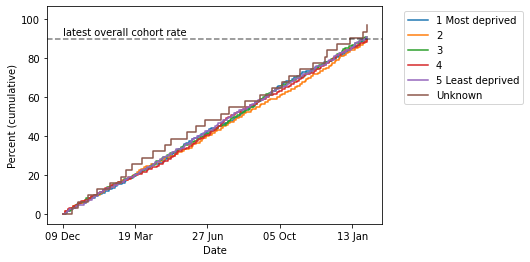

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **bmi**

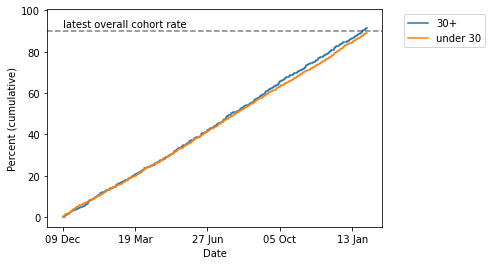

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **housebound**

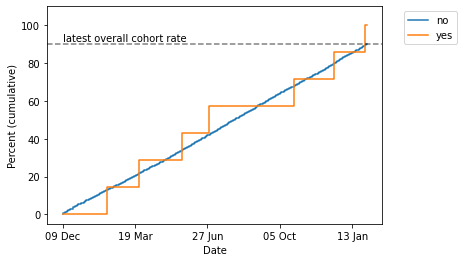

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **dementia**

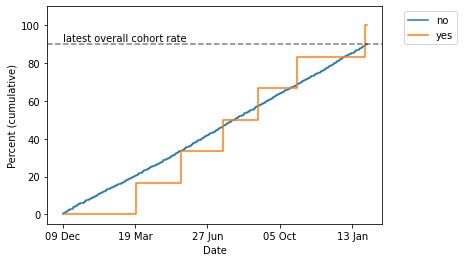

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

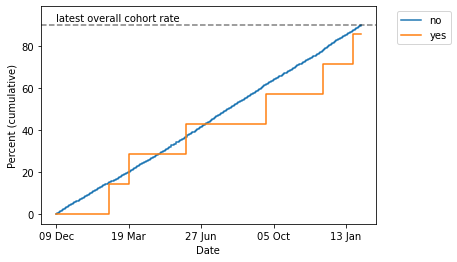

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **LD**

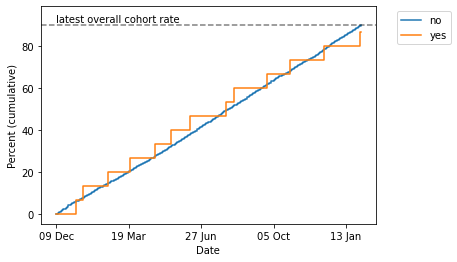

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **ssri**

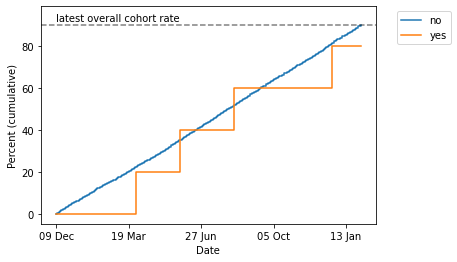

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **ckd**

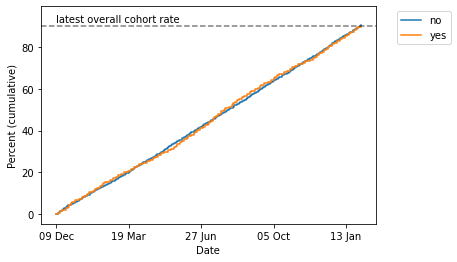

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

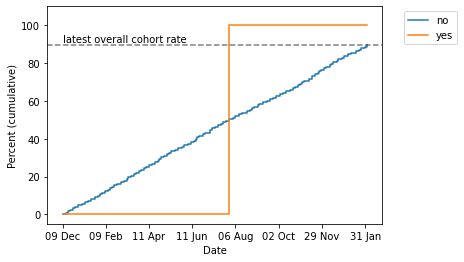

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

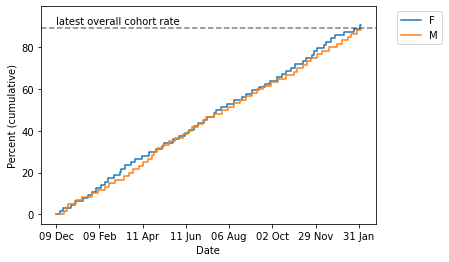

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

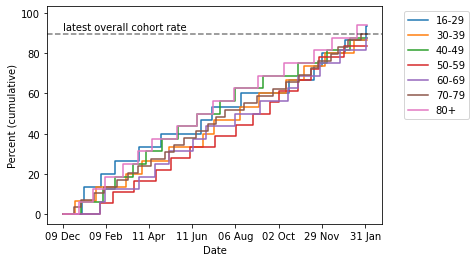

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

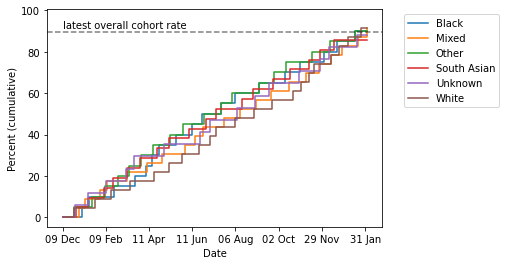

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

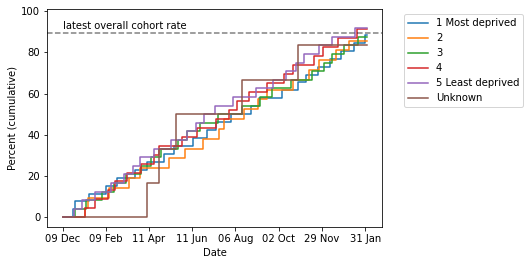

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

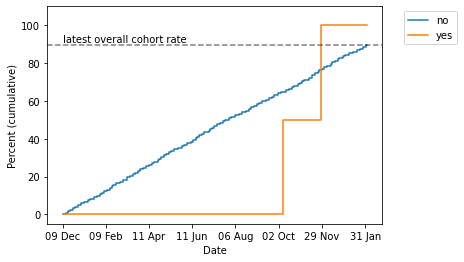

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **ckd**

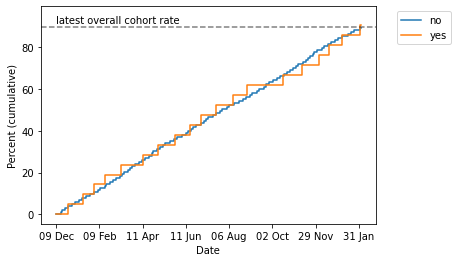

## 
 ## COVID vaccination rollout among **60-64** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **sex**

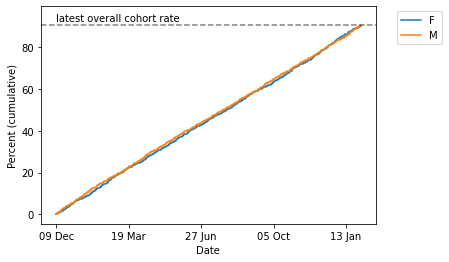

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

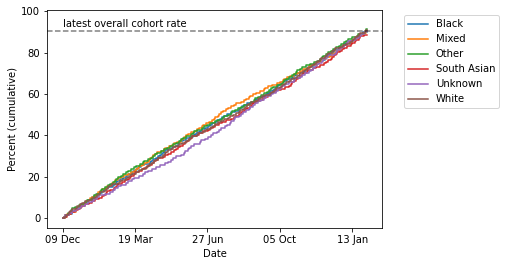

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **imd categories**

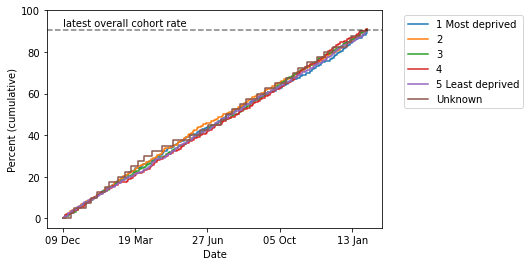

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **bmi**

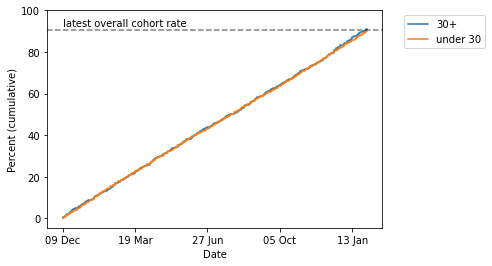

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **dementia**

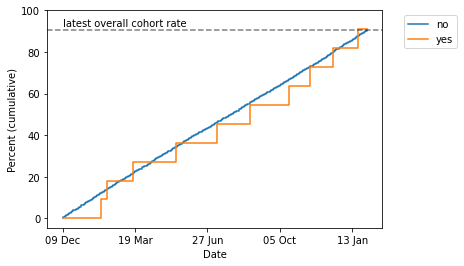

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

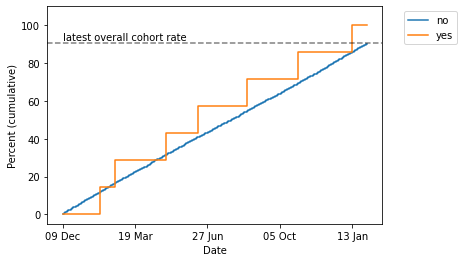

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **ssri**

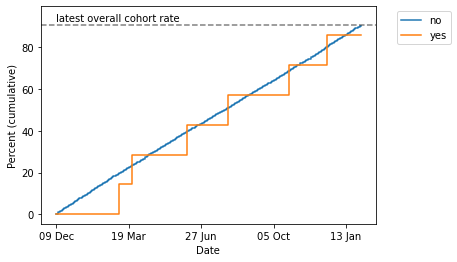

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **ckd**

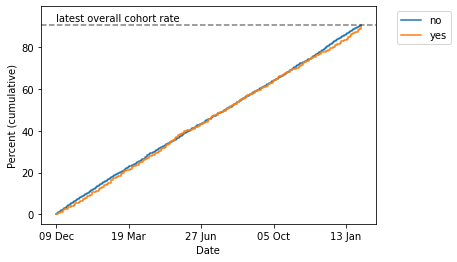

## 
 ## COVID vaccination rollout among **55-59** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **sex**

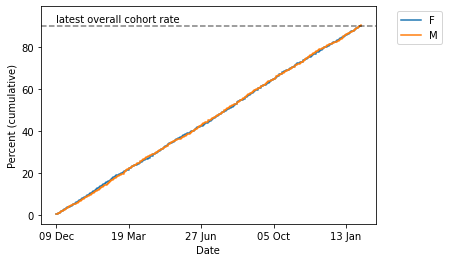

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

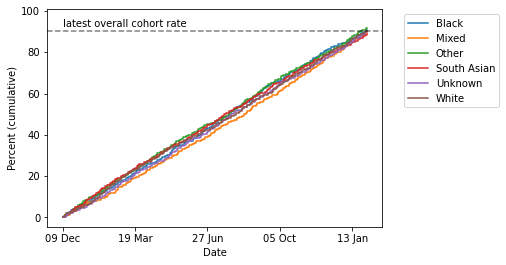

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **imd categories**

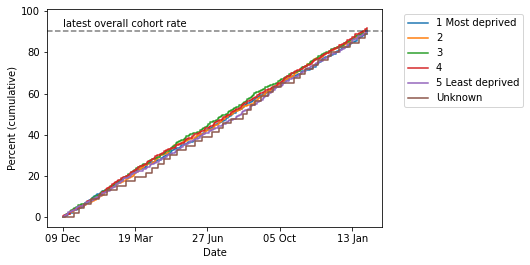

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **bmi**

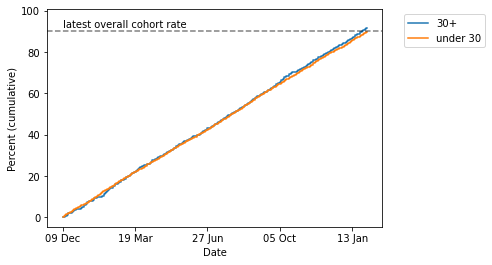

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

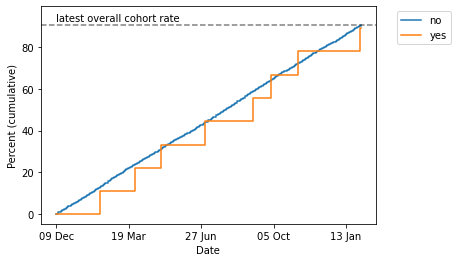

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **ssri**

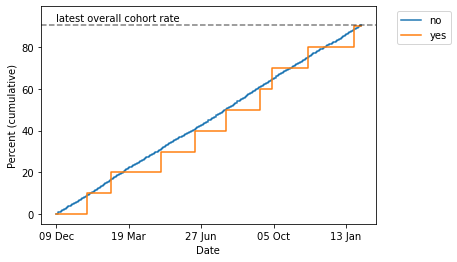

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **ckd**

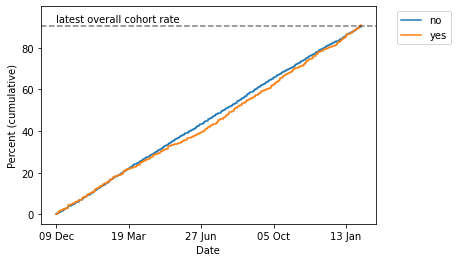

## 
 ## COVID vaccination rollout among **50-54** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **sex**

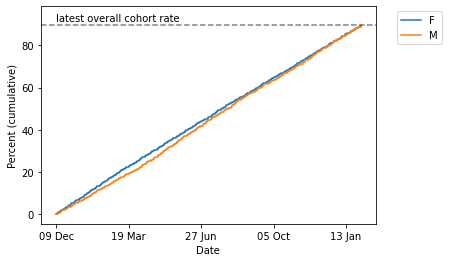

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

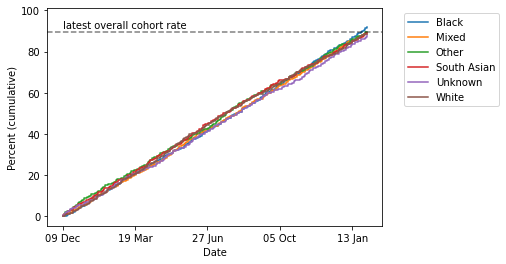

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **imd categories**

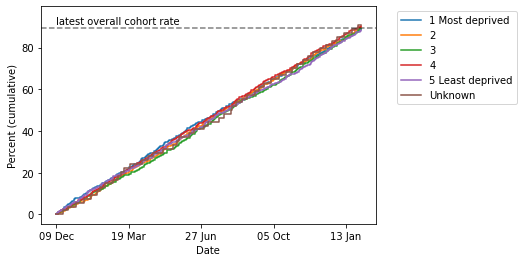

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **bmi**

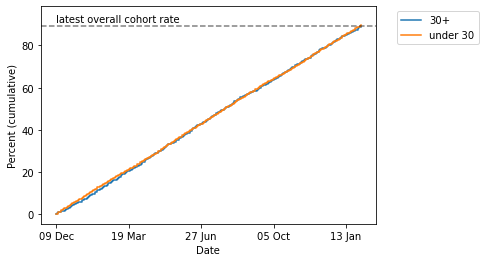

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

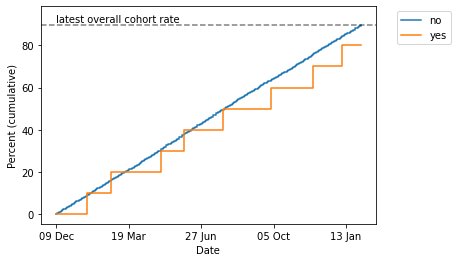

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **ssri**

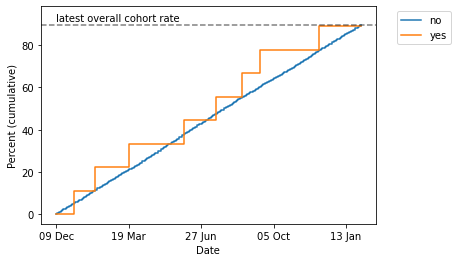

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **ckd**

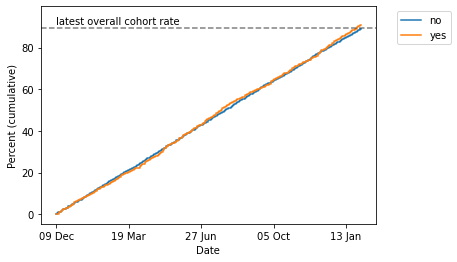

## 
 ## COVID vaccination rollout among **40-49** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **sex**

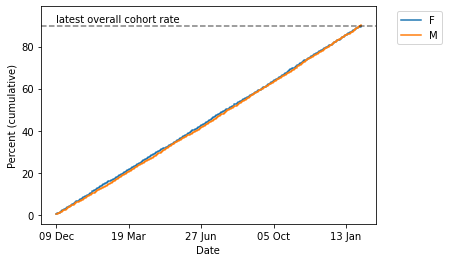

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **ethnicity 6 groups**

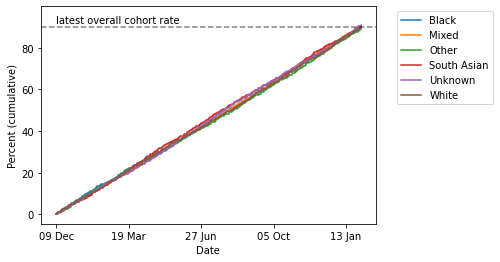

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **imd categories**

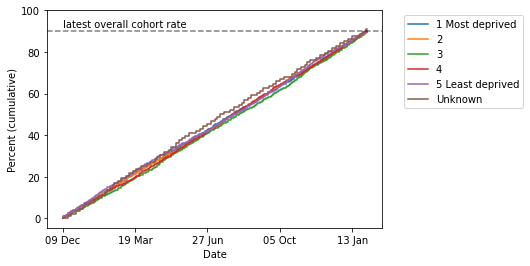

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **bmi**

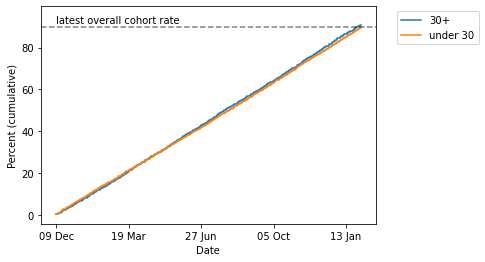

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **psychosis schiz bipolar**

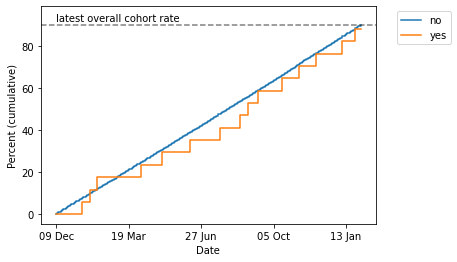

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **ssri**

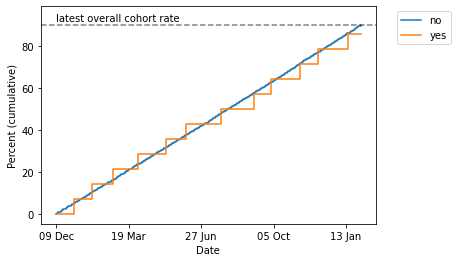

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **ckd**

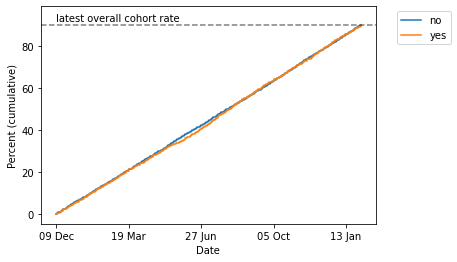

## 
 ## COVID vaccination rollout among **30-39** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **30-39** population by **sex**

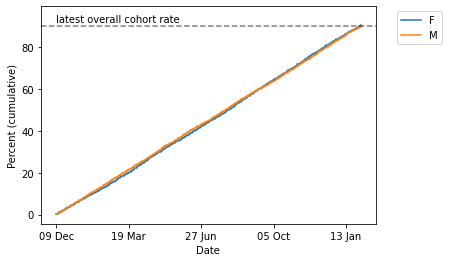

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **30-39** population by **ethnicity 6 groups**

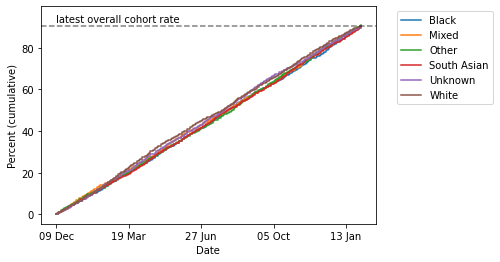

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **30-39** population by **imd categories**

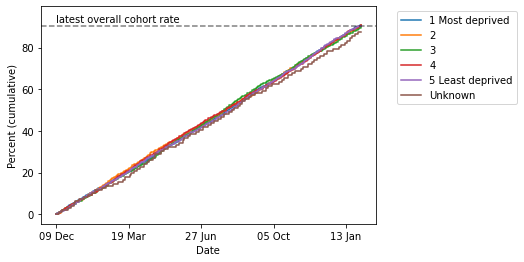

## 
 ## COVID vaccination rollout among **18-29** population up to 02 Feb 2022

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **18-29** population by **sex**

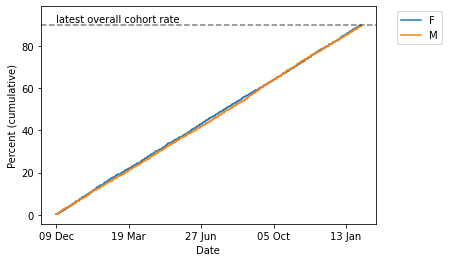

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **18-29** population by **ethnicity 6 groups**

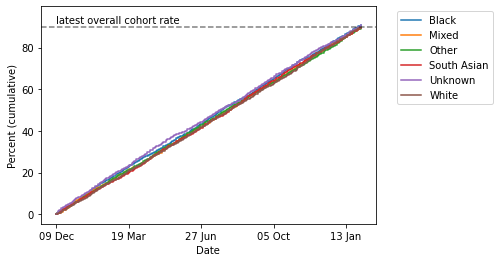

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **18-29** population by **imd categories**

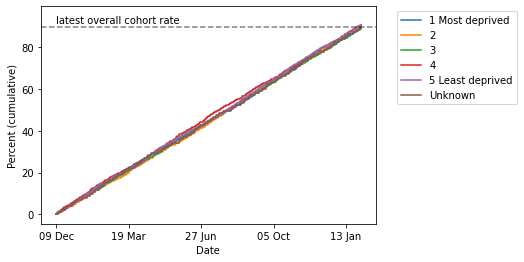

In [28]:


plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54", "40-49", "30-39", "18-29"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "current_copd", "chronic_cardiac_disease", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)


# ## Completeness of ethnicity recording

In [29]:


from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


# # Second doses

Total **80+** population with ethnicity recorded 3,619 (85.7%)

Total **70-79** population with ethnicity recorded 5,831 (85.0%)

Total **care home** population with ethnicity recorded 2,380 (84.4%)

Total **shielding (aged 16-69)** population with ethnicity recorded 749 (86.3%)

Total **65-69** population with ethnicity recorded 3,710 (84.0%)

Total **LD (aged 16-64)** population with ethnicity recorded 1,372 (85.6%)

Total **60-64** population with ethnicity recorded 4,634 (85.0%)

Total **55-59** population with ethnicity recorded 5,271 (84.7%)

Total **50-54** population with ethnicity recorded 5,733 (85.2%)

Total **40-49** population with ethnicity recorded 10,353 (84.5%)

Total **30-39** population with ethnicity recorded 11,039 (85.2%)

Total **18-29** population with ethnicity recorded 12,733 (85.1%)

Total **16-17** population with ethnicity recorded 17,598 (85.3%)

In [30]:


# only count second doses where the first dose was given at least 14 weeks ago 
# to allow comparison of the first dose situation 14w ago with the second dose situation now
# otherwise bias could be introduced from any second doses given early in certain subgroups

def subtract_from_date(s, unit, number, description):
    '''
    s (series): a series of date-like strings
    unit (str) : days/weeks
    number (int): number of days/weeks to subtract
    description (str): description of new date calculated to use as filename
    '''
    if unit == "weeks":
        new_date = pd.to_datetime(s).max() - timedelta(weeks=number)
    elif unit == "days":
        new_date = pd.to_datetime(s).max() - timedelta(days=number)
    else:
        display("invalid unit")
        return
    new_date = str(new_date)[:10]

    formatted_date = datetime.strptime(new_date, "%Y-%m-%d").strftime("%d %b %Y")
    with open(os.path.join(savepath["text"], f"{description}.txt"), "w") as text_file:
            text_file.write(formatted_date)
    with open(os.path.join(savepath["text"], f"{description}_specified_delay.txt"), "w") as text_file:
        formatted_delay = f"{number} {unit}"
        text_file.write(formatted_delay)

    display(Markdown(formatted_date))
    return new_date, formatted_date
    

date_14w, formatted_date_14w = subtract_from_date(s=df["covid_vacc_date"], unit="weeks", number=14,
                                             description="latest_date_of_first_dose_for_due_second_doses")

27 Oct 2021

In [31]:


# filter data
df_s = df.copy()
# replace any second doses not yet "due" with "0"
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) >= date_14w), "covid_vacc_second_dose_date"] = 0

# also ensure that first dose was dated after the start of the campaign, otherwise date is likely incorrect 
# and due date for second dose cannot be calculated accurately
# this also excludes any second doses where first dose date = 0 (this should affect dummy data only!)
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_second_dose_date"] = 0

In [32]:


# add "brand of first dose" to list of features to break down by
import copy
features_dict_2 = copy.deepcopy(features_dict)

for k in features_dict_2:
    ls = list(features_dict_2[k])
    ls.append("brand_of_first_dose") 
    features_dict_2[k] = ls

In [33]:


# data processing / summarising
df_dict_cum_second_dose = cumulative_sums(df_s, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

second_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

create_detailed_summary_uptake(second_dose_summarised_data_dict, formatted_latest_date, 
                               groups=groups,
                               savepath=savepath, vaccine_type="second_dose")

# ## For comparison look at first doses UP TO 14 WEEKS AGO
#

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (second dose) among **80+** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2317   
sex                       F                                          1204   
                          M                                          1106   
ageband_5yr               0                                            35   
                          0-15                                        133   
                          16-17                                       140   
                          18-29                                       154   
                          30-34                                       154   
                          35-39                                       154   
                          40-44                                       154   
                          45-49                                       161   
                          50-54                                       140   
                          55-59                                       168   
                          60-64                                       133   
                          65-69                                       154   
                          70-74                                       161   
                          75-79                                       161   
                          80-84                                       147   
                          85-89                                       154   
                          90+                                          14   
ethnicity_6_groups        Black                                       406   
                          Mixed                                       378   
                          Other                                       406   
                          South Asian                                 392   
                          Unknown                                     336   
                          White                                       392   
ethnicity_16_groups        African                                    133   
                           Bangladeshi or British Bangladeshi         105   
                           Caribbean                                  126   
                           Chinese                                    105   
                           Other                                      147   
                           Other Asian                                126   
                          British or Mixed British                    112   
                          Indian or British Indian                    119   
                          Irish                                       133   
                          Other Black                                 112   
                          Other White                                 133   
                          Other mixed                                  98   
                          Pakistani or British Pakistani              105   
                          Unknown                                     364   
                          White + Asian                               126   
                          White + Black African                       119   
                          White + Black Caribbean                     147   
imd_categories            1 Most deprived                             441   
                          2                                           434   
                          3                                           427   
                          4                                           448   
                          5 Least deprived                            448   
                          Unknown                                     119   
bmi                       30+                                         686   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **70-79** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3773   
sex                       F                                          1967   
                          M                                          1806   
ageband_5yr               0                                            49   
                          0-15                                        245   
                          16-17                                       238   
                          18-29                                       238   
                          30-34                                       259   
                          35-39                                       252   
                          40-44                                       217   
                          45-49                                       245   
                          50-54                                       259   
                          55-59                                       245   
                          60-64                                       245   
                          65-69                                       252   
                          70-74                                       238   
                          75-79                                       245   
                          80-84                                       245   
                          85-89                                       252   
                          90+                                          49   
ethnicity_6_groups        Black                                       637   
                          Mixed                                       658   
                          Other                                       644   
                          South Asian                                 672   
                          Unknown                                     581   
                          White                                       588   
ethnicity_16_groups        African                                    196   
                           Bangladeshi or British Bangladeshi         182   
                           Caribbean                                  210   
                           Chinese                                    210   
                           Other                                      189   
                           Other Asian                                203   
                          British or Mixed British                    196   
                          Indian or British Indian                    189   
                          Irish                                       210   
                          Other Black                                 189   
                          Other White                                 196   
                          Other mixed                                 189   
                          Pakistani or British Pakistani              182   
                          Unknown                                     567   
                          White + Asian                               224   
                          White + Black African                       217   
                          White + Black Caribbean                     224   
imd_categories            1 Most deprived                             721   
                          2                                           721   
                          3                                           700   
                          4                                           735   
                          5 Least deprived                            700   
                          Unknown                                     189   
bmi                       30+                                        1120   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **care home** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall            1533     54.3   2821   
sex                 F                   749     52.5   1428   
                    M                   777     56.1   1386   
ageband_5yr         0                    21     75.0     28   
                    0-15                 98     56.0    175   
                    16-17               119     60.7    196   
                    18-29                91     54.2    168   
                    30-34               105     55.6    189   
                    35-39               105     55.6    189   
                    40-44                84     50.0    168   
                    45-49                91     50.0    182   
                    50-54               105     57.7    182   
                    55-59                98     50.0    196   
                    60-64                98     50.0    196   
                    65-69                98     53.8    182   
                    70-74                91     48.1    189   
                    75-79                91     52.0    175   
                    80-84               105     57.7    182   
                    85-89               105     60.0    175   
                    90+                  28     57.1     49   
ethnicity_6_groups  Black               238     53.1    448   
                    Mixed               259     56.1    462   
                    Other               266     52.8    504   
                    South Asian         259     55.2    469   
                    Unknown             245     56.5    434   
                    White               259     52.9    490   
dementia            no                 1512     54.1   2793   
                    yes                  14     50.0     28   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Pfizer                0      0.0      0   
                    Unknown            1526     60.4   2527   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 53.1   
sex                 F                                       52.0   
                    M                                       54.5   
ageband_5yr         0                                       50.0   
                    0-15                                    56.0   
                    16-17                                   57.1   
                    18-29                                   54.2   
                    30-34                                   51.9   
                    35-39                                   55.6   
                    40-44                                   50.0   
                    45-49                                   50.0   
                    50-54                                   57.7   
                    55-59                                   50.0   
                    60-64                                   50.0   
                    65-69                                   53.8   
                    70-74                                   48.1   
                    75-79                                   52.0   
                    80-84                                   57.7   
                    85-89                                   60.0   
                    90+                                     57.1   
ethnicity_6_groups  Black                                   51.6   
                    Mixed                                   54.5   
                    Other                                   51.4   
                    South Asian                             53.7   
                    Unknown                                 56.5   
                    White                                   52.9   
dementia            no                           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **shielding (aged 16-69)** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  483     55.6    868   
newly_shielded_since_feb_15 no                       476     55.3    861   
                            yes                        7    100.0      7   
sex                         F                        259     57.8    448   
                            M                        231     55.0    420   
ageband                     16-29                     63     60.0    105   
                            30-39                     56     53.3    105   
                            40-49                     63     56.2    112   
                            50-59                     70     55.6    126   
                            60-69                     63     56.2    112   
                            70-79                    105     51.7    203   
                            80+                       70     62.5    112   
ethnicity_6_groups          Black                     77     55.0    140   
                            Mixed                     84     52.2    161   
                            Other                     91     65.0    140   
                            South Asian               84     57.1    147   
                            Unknown                   70     58.8    119   
                            White                     77     47.8    161   
imd_categories              1 Most deprived           98     53.8    182   
                            2                         84     57.1    147   
                            3                         98     58.3    168   
                            4                         91     56.5    161   
                            5 Least deprived          98     58.3    168   
                            Unknown                   28     66.7     42   
LD                          no                       476     55.7    854   
                            yes                        7     50.0     14   
ckd                         no                       399     55.3    721   
                            yes                       84     57.1    147   
brand_of_first_dose         Pfizer                     0      0.0      0   
                            Unknown                  483     62.2    777   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      55.6   
newly_shielded_since_feb_15 no                                           55.3   
                            yes                                         100.0   
sex                         F                                            56.2   
                            M                                            55.0   
ageband                     16-29                                        53.3   
                            30-39                                        53.3   
                            40-49                                        56.2   
                            50-59                                        50.0   
                            60-69                                        56.2   
                            70-79                                        51.7   
                            80+                                          62.5   
ethnicity_6_groups          Black                                        55.0   
                            Mixed                                        52.2   
                            Other                                        60.0   
                            South Asian                                  57.1   
                            Unknown                                      58.8   
                            White                                        4

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **65-69** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2415   
sex                       F                                          1197   
                          M                                          1218   
ethnicity_6_groups        Black                                       434   
                          Mixed                                       420   
                          Other                                       399   
                          South Asian                                 371   
                          Unknown                                     392   
                          White                                       406   
ethnicity_16_groups        African                                    133   
                           Bangladeshi or British Bangladeshi         119   
                           Caribbean                                  133   
                           Chinese                                    140   
                           Other                                      161   
                           Other Asian                                112   
                          British or Mixed British                    140   
                          Indian or British Indian                    126   
                          Irish                                       133   
                          Other Black                                 140   
                          Other White                                 126   
                          Other mixed                                 126   
                          Pakistani or British Pakistani              133   
                          Unknown                                     329   
                          White + Asian                               112   
                          White + Black African                       119   
                          White + Black Caribbean                     133   
imd_categories            1 Most deprived                             448   
                          2                                           441   
                          3                                           476   
                          4                                           469   
                          5 Least deprived                            462   
                          Unknown                                     126   
bmi                       30+                                         770   
                          under 30                                   1645   
housebound                no                                         2394   
                          yes                                          28   
chronic_cardiac_disease   no                                         2394   
                          yes                                          28   
current_copd              no                                         2387   
                          yes                                          28   
dmards                    no                                         2387   
                          yes                                          28   
dementia                  no                                         2394   
                          yes                                          21   
psychosis_schiz_bipolar   no                                         2394   
                          yes                                          21   
LD                        no                                         2359   
                          yes                                          56   
ssri                      no                                         2401   
                          yes                                          14   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **LD (aged 16-64)** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             931     58.1   1603   
sex                 F                   448     56.6    791   
                    M                   483     59.5    812   
ageband_5yr         0                    14     66.7     21   
                    0-15                 49     46.7    105   
                    16-17                70     62.5    112   
                    18-29                63     60.0    105   
                    30-34                63     64.3     98   
                    35-39                63     60.0    105   
                    40-44                49     58.3     84   
                    45-49                70     58.8    119   
                    50-54                70     52.6    133   
                    55-59                63     60.0    105   
                    60-64                63     64.3     98   
                    65-69                49     50.0     98   
                    70-74                49     53.8     91   
                    75-79                70     66.7    105   
                    80-84                56     57.1     98   
                    85-89                63     60.0    105   
                    90+                   7     50.0     14   
ethnicity_6_groups  Black               147     53.8    273   
                    Mixed               161     57.5    280   
                    Other               182     61.9    294   
                    South Asian         140     51.3    273   
                    Unknown             133     59.4    224   
                    White               168     64.9    259   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Pfizer                0      0.0      0   
                    Unknown             931     63.9   1456   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 57.2   
sex                 F                                       55.8   
                    M                                       58.6   
ageband_5yr         0                                       66.7   
                    0-15                                    46.7   
                    16-17                                   62.5   
                    18-29                                   60.0   
                    30-34                                   64.3   
                    35-39                                   60.0   
                    40-44                                   58.3   
                    45-49                                   58.8   
                    50-54                                   52.6   
                    55-59                                   60.0   
                    60-64                                   57.1   
                    65-69                                   50.0   
                    70-74                                   53.8   
                    75-79                                   66.7   
                    80-84                                   57.1   
                    85-89                                   60.0   
                    90+                                     50.0   
ethnicity_6_groups  Black                                   53.8   
                    Mixed                                   57.5   
                    Other                                   59.5   
                    South Asian                             51.3   
                    Unknown                                 59.4   
                    White                                   62.2   
brand_of_first_dose Oxford-AZ                                NaN   
                    Pfizer                                   NaN   
                    Unknown            

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **60-64** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2982   
sex                       F                                          1526   
                          M                                          1456   
ethnicity_6_groups        Black                                       539   
                          Mixed                                       532   
                          Other                                       497   
                          South Asian                                 483   
                          Unknown                                     448   
                          White                                       490   
ethnicity_16_groups        African                                    154   
                           Bangladeshi or British Bangladeshi         154   
                           Caribbean                                  175   
                           Chinese                                    154   
                           Other                                      154   
                           Other Asian                                189   
                          British or Mixed British                    133   
                          Indian or British Indian                    161   
                          Irish                                       147   
                          Other Black                                 168   
                          Other White                                 147   
                          Other mixed                                 147   
                          Pakistani or British Pakistani              175   
                          Unknown                                     427   
                          White + Asian                               161   
                          White + Black African                       175   
                          White + Black Caribbean                     161   
imd_categories            1 Most deprived                             532   
                          2                                           574   
                          3                                           609   
                          4                                           546   
                          5 Least deprived                            574   
                          Unknown                                     147   
bmi                       30+                                         882   
                          under 30                                   2107   
chronic_cardiac_disease   no                                         2961   
                          yes                                          21   
current_copd              no                                         2954   
                          yes                                          28   
dmards                    no                                         2954   
                          yes                                          28   
dementia                  no                                         2940   
                          yes                                          42   
psychosis_schiz_bipolar   no                                         2954   
                          yes                                          28   
ssri                      no                                         2961   
                          yes                                          28   
chemo_or_radio            no                                         2947   
                          yes                                          35   
lung_cancer               no                                         2954   
                          yes                                          28   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **55-59** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3472   
sex                     F                                          1764   
                        M                                          1701   
ethnicity_6_groups      Black                                       581   
                        Mixed                                       567   
                        Other                                       630   
                        South Asian                                 574   
                        Unknown                                     518   
                        White                                       595   
ethnicity_16_groups      African                                    168   
                         Bangladeshi or British Bangladeshi         161   
                         Caribbean                                  189   
                         Chinese                                    161   
                         Other                                      196   
                         Other Asian                                175   
                        British or Mixed British                    189   
                        Indian or British Indian                    175   
                        Irish                                       182   
                        Other Black                                 203   
                        Other White                                 189   
                        Other mixed                                 189   
                        Pakistani or British Pakistani              210   
                        Unknown                                     518   
                        White + Asian                               175   
                        White + Black African                       217   
                        White + Black Caribbean                     182   
imd_categories          1 Most deprived                             679   
                        2                                           644   
                        3                                           686   
                        4                                           672   
                        5 Least deprived                            623   
                        Unknown                                     168   
bmi                     30+                                        1015   
                        under 30                                   2450   
chronic_cardiac_disease no                                         3430   
                        yes                                          42   
current_copd            no                                         3444   
                        yes                                          21   
dmards                  no                                         3430   
                        yes                                          42   
psychosis_schiz_bipolar no                                         3437   
                        yes                                          35   
ssri                    no                                         3437   
                        yes                                          35   
ckd                     no                                         2779   
                        yes                                         693   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    3465   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 55.8   6223  

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **50-54** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3647   
sex                     F                                          1855   
                        M                                          1799   
ethnicity_6_groups      Black                                       637   
                        Mixed                                       637   
                        Other                                       609   
                        South Asian                                 588   
                        Unknown                                     532   
                        White                                       651   
ethnicity_16_groups      African                                    189   
                         Bangladeshi or British Bangladeshi         189   
                         Caribbean                                  196   
                         Chinese                                    196   
                         Other                                      182   
                         Other Asian                                203   
                        British or Mixed British                    196   
                        Indian or British Indian                    224   
                        Irish                                       189   
                        Other Black                                 203   
                        Other White                                 168   
                        Other mixed                                 175   
                        Pakistani or British Pakistani              217   
                        Unknown                                     560   
                        White + Asian                               168   
                        White + Black African                       189   
                        White + Black Caribbean                     203   
imd_categories          1 Most deprived                             693   
                        2                                           700   
                        3                                           686   
                        4                                           707   
                        5 Least deprived                            651   
                        Unknown                                     210   
bmi                     30+                                        1071   
                        under 30                                   2583   
chronic_cardiac_disease no                                         3619   
                        yes                                          35   
current_copd            no                                         3612   
                        yes                                          42   
dmards                  no                                         3619   
                        yes                                          28   
psychosis_schiz_bipolar no                                         3612   
                        yes                                          35   
ssri                    no                                         3612   
                        yes                                          42   
ckd                     no                                         2926   
                        yes                                         728   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    3640   

                                                             percent  total  \
category                group                                                 
ov

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **40-49** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    6734   
sex                     F                                          3521   
                        M                                          3213   
ethnicity_6_groups      Black                                      1162   
                        Mixed                                      1134   
                        Other                                      1099   
                        South Asian                                1134   
                        Unknown                                    1078   
                        White                                      1134   
ethnicity_16_groups      African                                    364   
                         Bangladeshi or British Bangladeshi         329   
                         Caribbean                                  399   
                         Chinese                                    343   
                         Other                                      371   
                         Other Asian                                336   
                        British or Mixed British                    357   
                        Indian or British Indian                    357   
                        Irish                                       399   
                        Other Black                                 357   
                        Other White                                 385   
                        Other mixed                                 357   
                        Pakistani or British Pakistani              343   
                        Unknown                                     994   
                        White + Asian                               315   
                        White + Black African                       357   
                        White + Black Caribbean                     378   
imd_categories          1 Most deprived                            1281   
                        2                                          1295   
                        3                                          1253   
                        4                                          1267   
                        5 Least deprived                           1302   
                        Unknown                                     336   
bmi                     30+                                        2058   
                        under 30                                   4683   
chronic_cardiac_disease no                                         6657   
                        yes                                          84   
current_copd            no                                         6671   
                        yes                                          63   
dmards                  no                                         6664   
                        yes                                          77   
psychosis_schiz_bipolar no                                         6678   
                        yes                                          56   
ssri                    no                                         6685   
                        yes                                          49   
ckd                     no                                         5411   
                        yes                                        1323   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        7   
                        Unknown                                    6720   

                                                             percent  total  \
category                group                                                 
ov

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **30-39** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    7168     55.3   
sex                 F                                          3752     55.8   
                    M                                          3409     54.7   
ethnicity_6_groups  Black                                      1225     54.9   
                    Mixed                                      1204     54.6   
                    Other                                      1169     54.9   
                    South Asian                                1225     54.3   
                    Unknown                                    1078     56.2   
                    White                                      1260     56.6   
ethnicity_16_groups  African                                    371     53.0   
                     Bangladeshi or British Bangladeshi         385     56.1   
                     Caribbean                                  350     53.2   
                     Chinese                                    371     53.0   
                     Other                                      385     56.7   
                     Other Asian                                392     54.9   
                    British or Mixed British                    371     52.0   
                    Indian or British Indian                    364     53.1   
                    Irish                                       371     57.6   
                    Other Black                                 385     55.6   
                    Other White                                 385     58.5   
                    Other mixed                                 392     56.6   
                    Pakistani or British Pakistani              413     56.2   
                    Unknown                                    1071     56.0   
                    White + Asian                               371     53.5   
                    White + Black African                       406     56.3   
                    White + Black Caribbean                     371     55.8   
imd_categories      1 Most deprived                            1351     54.7   
                    2                                          1365     55.1   
                    3                                          1358     55.4   
                    4                                          1351     55.1   
                    5 Least deprived                           1386     56.9   
                    Unknown                                     357     53.1   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    7154     61.2   

                                                         total  \
category            group                                        
overall             overall                              12957   
sex                 F                                     6727   
                    M                                     6230   
ethnicity_6_groups  Black                                 2233   
                    Mixed                                 2205   
                    Other                                 2128   
                    South Asian                           2254   
                    Unknown                               1918   
                    White                                 2226   
ethnicity_16_groups  African                               700   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             658   
                     Chinese                               700   
                     Other

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **18-29** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    8260     55.2   
sex                 F                                          4242     55.2   
                    M                                          4025     55.2   
ethnicity_6_groups  Black                                      1435     56.2   
                    Mixed                                      1407     54.6   
                    Other                                      1379     53.8   
                    South Asian                                1428     56.8   
                    Unknown                                    1267     56.7   
                    White                                      1351     53.6   
ethnicity_16_groups  African                                    441     56.2   
                     Bangladeshi or British Bangladeshi         448     55.7   
                     Caribbean                                  420     53.6   
                     Chinese                                    455     56.0   
                     Other                                      448     56.1   
                     Other Asian                                420     53.6   
                    British or Mixed British                    420     55.0   
                    Indian or British Indian                    441     53.4   
                    Irish                                       448     58.2   
                    Other Black                                 448     56.1   
                    Other White                                 427     54.0   
                    Other mixed                                 469     59.3   
                    Pakistani or British Pakistani              427     56.0   
                    Unknown                                    1246     54.8   
                    White + Asian                               441     53.4   
                    White + Black African                       420     52.2   
                    White + Black Caribbean                     441     55.8   
imd_categories      1 Most deprived                            1596     54.3   
                    2                                          1554     54.8   
                    3                                          1547     54.4   
                    4                                          1617     56.6   
                    5 Least deprived                           1568     56.4   
                    Unknown                                     385     53.4   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     7     50.0   
                    Pfizer                                       14     66.7   
                    Unknown                                    8239     61.5   

                                                         total  \
category            group                                        
overall             overall                              14966   
sex                 F                                     7686   
                    M                                     7287   
ethnicity_6_groups  Black                                 2555   
                    Mixed                                 2576   
                    Other                                 2562   
                    South Asian                           2513   
                    Unknown                               2233   
                    White                                 2520   
ethnicity_16_groups  African                               784   
                     Bangladeshi or British Bangladeshi    805   
                     Caribbean                             784   
                     Chinese                               812   
                     Other

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **16-17** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                11354     55.0  20636   
sex                 F                       5796     55.1  10514   
                    M                       5565     55.0  10115   
ethnicity_6_groups  Black                   1932     55.2   3500   
                    Mixed                   1918     54.0   3549   
                    Other                   1988     56.3   3528   
                    South Asian             1904     53.6   3549   
                    Unknown                 1715     56.6   3031   
                    White                   1904     54.8   3472   
imd_categories      1 Most deprived         2156     54.2   3976   
                    2                       2128     54.8   3885   
                    3                       2247     57.1   3934   
                    4                       2093     53.3   3927   
                    5 Least deprived        2149     55.5   3871   
                    Unknown                  581     55.3   1050   
brand_of_first_dose Moderna                    0      0.0      7   
                    Oxford-AZ                  7     50.0     14   
                    Pfizer                    21     50.0     42   
                    Unknown                11319     61.2  18487   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      54.2   
sex                 F                                            54.2   
                    M                                            54.3   
ethnicity_6_groups  Black                                        54.4   
                    Mixed                                        53.3   
                    Other                                        55.2   
                    South Asian                                  52.9   
                    Unknown                                      55.4   
                    White                                        54.2   
imd_categories      1 Most deprived                              53.5   
                    2                                            54.1   
                    3                                            56.2   
                    4                                            52.6   
                    5 Least deprived                             54.4   
                    Unknown                                      54.7   
brand_of_first_dose Moderna                                       0.0   
                    Oxford-AZ                                    50.0   
                    Pfizer                                       50.0   
                    Unknown                                      60.3   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    0.8   
sex                 F                                          0.9   
                    M                                          0.7   
ethnicity_6_groups  Black                                      0.8   
                    Mixed                                      0.7   
                    Other                                      1.1   
                    South Asian                                0.7   
                    Unknown                                    1.2   
                    White                                      0.6   
imd_categories      1 Most deprived                            0.7   
                    2                                          0.7   
                    3                                          0.9   
                    4                                          0.7   
                    5 Lea

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


In [34]:


# latest date of 14 weeks ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that first dose was dated after the start of the campaign, 
# to be consistent with the second doses due calculated above
df_14w = df.copy()
df_14w.loc[(pd.to_datetime(df_14w["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_date"] = 0


df_dict_cum_14w = cumulative_sums(
                                  df_14w, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                  latest_date=date_14w
                                  )

summarised_data_dict_14w = summarise_data_by_group(
                                                   df_dict_cum_14w, 
                                                   latest_date=date_14w, 
                                                   groups=groups
                                                   )

create_detailed_summary_uptake(summarised_data_dict_14w, formatted_latest_date=date_14w, 
                               groups=groups,
                               savepath=savepath, vaccine_type="first_dose_14w_ago")


# # Booster/third doses

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (first dose 14w ago) among **80+** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2933   
sex                       F                                          1512   
                          M                                          1421   
ageband_5yr               0                                            42   
                          0-15                                        182   
                          16-17                                       175   
                          18-29                                       189   
                          30-34                                       182   
                          35-39                                       189   
                          40-44                                       196   
                          45-49                                       196   
                          50-54                                       189   
                          55-59                                       210   
                          60-64                                       182   
                          65-69                                       189   
                          70-74                                       203   
                          75-79                                       203   
                          80-84                                       189   
                          85-89                                       203   
                          90+                                          14   
ethnicity_6_groups        Black                                       504   
                          Mixed                                       476   
                          Other                                       525   
                          South Asian                                 518   
                          Unknown                                     427   
                          White                                       490   
ethnicity_16_groups        African                                    168   
                           Bangladeshi or British Bangladeshi         133   
                           Caribbean                                  161   
                           Chinese                                    133   
                           Other                                      182   
                           Other Asian                                147   
                          British or Mixed British                    147   
                          Indian or British Indian                    147   
                          Irish                                       161   
                          Other Black                                 147   
                          Other White                                 161   
                          Other mixed                                 140   
                          Pakistani or British Pakistani              154   
                          Unknown                                     462   
                          White + Asian                               154   
                          White + Black African                       161   
                          White + Black Caribbean                     175   
imd_categories            1 Most deprived                             560   
                          2                                           574   
                          3                                           539   
                          4                                           567   
                          5 Least deprived                            546   
                          Unknown                                     147   
bmi                       30+                                         896   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **70-79** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    4753   
sex                       F                                          2478   
                          M                                          2268   
ageband_5yr               0                                            63   
                          0-15                                        294   
                          16-17                                       301   
                          18-29                                       287   
                          30-34                                       343   
                          35-39                                       308   
                          40-44                                       287   
                          45-49                                       308   
                          50-54                                       322   
                          55-59                                       308   
                          60-64                                       315   
                          65-69                                       315   
                          70-74                                       301   
                          75-79                                       315   
                          80-84                                       301   
                          85-89                                       322   
                          90+                                          63   
ethnicity_6_groups        Black                                       805   
                          Mixed                                       826   
                          Other                                       826   
                          South Asian                                 826   
                          Unknown                                     721   
                          White                                       742   
ethnicity_16_groups        African                                    252   
                           Bangladeshi or British Bangladeshi         245   
                           Caribbean                                  259   
                           Chinese                                    245   
                           Other                                      252   
                           Other Asian                                259   
                          British or Mixed British                    238   
                          Indian or British Indian                    259   
                          Irish                                       252   
                          Other Black                                 252   
                          Other White                                 252   
                          Other mixed                                 231   
                          Pakistani or British Pakistani              224   
                          Unknown                                     707   
                          White + Asian                               266   
                          White + Black African                       273   
                          White + Black Caribbean                     273   
imd_categories            1 Most deprived                             889   
                          2                                           931   
                          3                                           889   
                          4                                           903   
                          5 Least deprived                            903   
                          Unknown                                     231   
bmi                       30+                                        1421   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **care home** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall            1960     69.5   2821   
sex                 F                   987     69.1   1428   
                    M                   966     69.7   1386   
ageband_5yr         0                    21     75.0     28   
                    0-15                126     72.0    175   
                    16-17               140     71.4    196   
                    18-29               119     70.8    168   
                    30-34               140     74.1    189   
                    35-39               126     66.7    189   
                    40-44               112     66.7    168   
                    45-49               126     69.2    182   
                    50-54               126     69.2    182   
                    55-59               133     67.9    196   
                    60-64               126     64.3    196   
                    65-69               126     69.2    182   
                    70-74               126     66.7    189   
                    75-79               119     68.0    175   
                    80-84               126     69.2    182   
                    85-89               126     72.0    175   
                    90+                  42     85.7     49   
ethnicity_6_groups  Black               308     68.8    448   
                    Mixed               336     72.7    462   
                    Other               343     68.1    504   
                    South Asian         329     70.1    469   
                    Unknown             308     71.0    434   
                    White               329     67.1    490   
dementia            no                 1939     69.4   2793   
                    yes                  21     75.0     28   
brand_of_first_dose Moderna               0      0.0      0   
                    Oxford-AZ             0      0.0      0   
                    Pfizer                0      0.0      0   
                    Unknown            1953     77.3   2527   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 67.7   
sex                 F                                       67.6   
                    M                                       68.2   
ageband_5yr         0                                       75.0   
                    0-15                                    72.0   
                    16-17                                   67.9   
                    18-29                                   66.7   
                    30-34                                   74.1   
                    35-39                                   66.7   
                    40-44                                   62.5   
                    45-49                                   65.4   
                    50-54                                   69.2   
                    55-59                                   67.9   
                    60-64                                   64.3   
                    65-69                                   69.2   
                    70-74                                   66.7   
                    75-79                                   64.0   
                    80-84                                   65.4   
                    85-89                                   72.0   
                    90+                                     85.7   
ethnicity_6_groups  Black                                   65.6   
                    Mixed                                   71.2   
                    Other                                   66.7   
                    South Asian                             68.7   
                    Unknown                                 71.0   
                    White                             

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **shielding (aged 16-69)** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  588     67.7    868   
newly_shielded_since_feb_15 no                       574     66.7    861   
                            yes                        7    100.0      7   
sex                         F                        308     68.8    448   
                            M                        280     66.7    420   
ageband                     16-29                     70     66.7    105   
                            30-39                     70     66.7    105   
                            40-49                     77     68.8    112   
                            50-59                     77     61.1    126   
                            60-69                     70     62.5    112   
                            70-79                    133     65.5    203   
                            80+                       84     75.0    112   
ethnicity_6_groups          Black                     98     70.0    140   
                            Mixed                    105     65.2    161   
                            Other                    105     75.0    140   
                            South Asian              105     71.4    147   
                            Unknown                   77     64.7    119   
                            White                     98     60.9    161   
imd_categories              1 Most deprived          112     61.5    182   
                            2                         98     66.7    147   
                            3                        112     66.7    168   
                            4                        119     73.9    161   
                            5 Least deprived         119     70.8    168   
                            Unknown                   28     66.7     42   
LD                          no                       581     68.0    854   
                            yes                        7     50.0     14   
ckd                         no                       490     68.0    721   
                            yes                       98     66.7    147   
brand_of_first_dose         Pfizer                     0      0.0      0   
                            Unknown                  581     74.8    777   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      66.9   
newly_shielded_since_feb_15 no                                           66.7   
                            yes                                         100.0   
sex                         F                                            68.8   
                            M                                            66.7   
ageband                     16-29                                        66.7   
                            30-39                                        66.7   
                            40-49                                        68.8   
                            50-59                                        61.1   
                            60-69                                        62.5   
                            70-79                                        65.5   
                            80+                                          75.0   
ethnicity_6_groups          Black                                        70.0   
                            Mixed                                        65.2   
                            Other                                        75.0   
                            South Asian                                  71.4   
                            Unknown                                      64.7   
                            White                                        6

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **65-69** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3017   
sex                       F                                          1505   
                          M                                          1519   
ethnicity_6_groups        Black                                       518   
                          Mixed                                       532   
                          Other                                       504   
                          South Asian                                 469   
                          Unknown                                     490   
                          White                                       504   
ethnicity_16_groups        African                                    168   
                           Bangladeshi or British Bangladeshi         154   
                           Caribbean                                  175   
                           Chinese                                    168   
                           Other                                      189   
                           Other Asian                                140   
                          British or Mixed British                    161   
                          Indian or British Indian                    168   
                          Irish                                       175   
                          Other Black                                 168   
                          Other White                                 168   
                          Other mixed                                 154   
                          Pakistani or British Pakistani              161   
                          Unknown                                     413   
                          White + Asian                               147   
                          White + Black African                       140   
                          White + Black Caribbean                     168   
imd_categories            1 Most deprived                             574   
                          2                                           546   
                          3                                           595   
                          4                                           567   
                          5 Least deprived                            581   
                          Unknown                                     154   
bmi                       30+                                         952   
                          under 30                                   2065   
housebound                no                                         2989   
                          yes                                          35   
chronic_cardiac_disease   no                                         2989   
                          yes                                          28   
current_copd              no                                         2982   
                          yes                                          35   
dmards                    no                                         2982   
                          yes                                          35   
dementia                  no                                         2989   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         2989   
                          yes                                          28   
LD                        no                                         2947   
                          yes                                          70   
ssri                      no                                         2996   
                          yes                                          21   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **LD (aged 16-64)** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall            1155     72.1   1603   
sex                 F                   567     71.7    791   
                    M                   588     72.4    812   
ageband_5yr         0                    14     66.7     21   
                    0-15                 70     66.7    105   
                    16-17                84     75.0    112   
                    18-29                77     73.3    105   
                    30-34                70     71.4     98   
                    35-39                77     73.3    105   
                    40-44                63     75.0     84   
                    45-49                84     70.6    119   
                    50-54                84     63.2    133   
                    55-59                77     73.3    105   
                    60-64                77     78.6     98   
                    65-69                63     64.3     98   
                    70-74                56     61.5     91   
                    75-79                84     80.0    105   
                    80-84                70     71.4     98   
                    85-89                84     80.0    105   
                    90+                  14    100.0     14   
ethnicity_6_groups  Black               189     69.2    273   
                    Mixed               203     72.5    280   
                    Other               224     76.2    294   
                    South Asian         189     69.2    273   
                    Unknown             161     71.9    224   
                    White               196     75.7    259   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Pfizer                0      0.0      0   
                    Unknown            1155     79.3   1456   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 70.3   
sex                 F                                       69.9   
                    M                                       70.7   
ageband_5yr         0                                       66.7   
                    0-15                                    66.7   
                    16-17                                   75.0   
                    18-29                                   66.7   
                    30-34                                   71.4   
                    35-39                                   73.3   
                    40-44                                   75.0   
                    45-49                                   70.6   
                    50-54                                   63.2   
                    55-59                                   73.3   
                    60-64                                   78.6   
                    65-69                                   64.3   
                    70-74                                   61.5   
                    75-79                                   80.0   
                    80-84                                   71.4   
                    85-89                                   80.0   
                    90+                                     50.0   
ethnicity_6_groups  Black                                   66.7   
                    Mixed                                   70.0   
                    Other                                   71.4   
                    South Asian                             66.7   
                    Unknown                                 71.9   
                    White                                   73.0   
brand_of_first_dose Oxford-AZ                                NaN   
                    Pfizer                                   NaN   
                    Unknown            

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **60-64** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3752   
sex                       F                                          1918   
                          M                                          1827   
ethnicity_6_groups        Black                                       665   
                          Mixed                                       658   
                          Other                                       623   
                          South Asian                                 616   
                          Unknown                                     553   
                          White                                       637   
ethnicity_16_groups        African                                    196   
                           Bangladeshi or British Bangladeshi         196   
                           Caribbean                                  217   
                           Chinese                                    196   
                           Other                                      189   
                           Other Asian                                217   
                          British or Mixed British                    168   
                          Indian or British Indian                    196   
                          Irish                                       182   
                          Other Black                                 196   
                          Other White                                 189   
                          Other mixed                                 189   
                          Pakistani or British Pakistani              224   
                          Unknown                                     553   
                          White + Asian                               203   
                          White + Black African                       217   
                          White + Black Caribbean                     210   
imd_categories            1 Most deprived                             679   
                          2                                           721   
                          3                                           749   
                          4                                           679   
                          5 Least deprived                            721   
                          Unknown                                     196   
bmi                       30+                                        1120   
                          under 30                                   2625   
chronic_cardiac_disease   no                                         3717   
                          yes                                          28   
current_copd              no                                         3717   
                          yes                                          35   
dmards                    no                                         3710   
                          yes                                          42   
dementia                  no                                         3703   
                          yes                                          49   
psychosis_schiz_bipolar   no                                         3710   
                          yes                                          35   
ssri                      no                                         3717   
                          yes                                          35   
chemo_or_radio            no                                         3703   
                          yes                                          49   
lung_cancer               no                                         3717   
                          yes                                          35   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **55-59** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4333   
sex                     F                                          2240   
                        M                                          2100   
ethnicity_6_groups      Black                                       735   
                        Mixed                                       707   
                        Other                                       784   
                        South Asian                                 721   
                        Unknown                                     651   
                        White                                       742   
ethnicity_16_groups      African                                    217   
                         Bangladeshi or British Bangladeshi         224   
                         Caribbean                                  231   
                         Chinese                                    189   
                         Other                                      231   
                         Other Asian                                217   
                        British or Mixed British                    238   
                        Indian or British Indian                    224   
                        Irish                                       231   
                        Other Black                                 245   
                        Other White                                 231   
                        Other mixed                                 231   
                        Pakistani or British Pakistani              259   
                        Unknown                                     644   
                        White + Asian                               217   
                        White + Black African                       259   
                        White + Black Caribbean                     238   
imd_categories          1 Most deprived                             847   
                        2                                           798   
                        3                                           854   
                        4                                           840   
                        5 Least deprived                            777   
                        Unknown                                     217   
bmi                     30+                                        1274   
                        under 30                                   3059   
chronic_cardiac_disease no                                         4291   
                        yes                                          49   
current_copd            no                                         4305   
                        yes                                          28   
dmards                  no                                         4284   
                        yes                                          49   
psychosis_schiz_bipolar no                                         4291   
                        yes                                          42   
ssri                    no                                         4284   
                        yes                                          49   
ckd                     no                                         3458   
                        yes                                         875   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    4326   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 69.6   6223  

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **50-54** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4613   
sex                     F                                          2345   
                        M                                          2268   
ethnicity_6_groups      Black                                       826   
                        Mixed                                       798   
                        Other                                       777   
                        South Asian                                 749   
                        Unknown                                     658   
                        White                                       812   
ethnicity_16_groups      African                                    245   
                         Bangladeshi or British Bangladeshi         245   
                         Caribbean                                  245   
                         Chinese                                    238   
                         Other                                      238   
                         Other Asian                                259   
                        British or Mixed British                    245   
                        Indian or British Indian                    280   
                        Irish                                       231   
                        Other Black                                 252   
                        Other White                                 231   
                        Other mixed                                 224   
                        Pakistani or British Pakistani              259   
                        Unknown                                     700   
                        White + Asian                               231   
                        White + Black African                       238   
                        White + Black Caribbean                     252   
imd_categories          1 Most deprived                             882   
                        2                                           903   
                        3                                           840   
                        4                                           882   
                        5 Least deprived                            847   
                        Unknown                                     259   
bmi                     30+                                        1351   
                        under 30                                   3262   
chronic_cardiac_disease no                                         4564   
                        yes                                          49   
current_copd            no                                         4557   
                        yes                                          56   
dmards                  no                                         4578   
                        yes                                          35   
psychosis_schiz_bipolar no                                         4571   
                        yes                                          42   
ssri                    no                                         4564   
                        yes                                          49   
ckd                     no                                         3682   
                        yes                                         931   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    4606   

                                                             percent  total  \
category                group                                                 
ov

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **40-49** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    8393   
sex                     F                                          4410   
                        M                                          3983   
ethnicity_6_groups      Black                                      1442   
                        Mixed                                      1442   
                        Other                                      1372   
                        South Asian                                1421   
                        Unknown                                    1309   
                        White                                      1407   
ethnicity_16_groups      African                                    455   
                         Bangladeshi or British Bangladeshi         434   
                         Caribbean                                  483   
                         Chinese                                    434   
                         Other                                      455   
                         Other Asian                                427   
                        British or Mixed British                    434   
                        Indian or British Indian                    441   
                        Irish                                       476   
                        Other Black                                 455   
                        Other White                                 476   
                        Other mixed                                 448   
                        Pakistani or British Pakistani              427   
                        Unknown                                    1232   
                        White + Asian                               399   
                        White + Black African                       448   
                        White + Black Caribbean                     462   
imd_categories          1 Most deprived                            1589   
                        2                                          1596   
                        3                                          1554   
                        4                                          1596   
                        5 Least deprived                           1624   
                        Unknown                                     434   
bmi                     30+                                        2534   
                        under 30                                   5852   
chronic_cardiac_disease no                                         8295   
                        yes                                          98   
current_copd            no                                         8302   
                        yes                                          84   
dmards                  no                                         8288   
                        yes                                          98   
psychosis_schiz_bipolar no                                         8316   
                        yes                                          77   
ssri                    no                                         8330   
                        yes                                          63   
ckd                     no                                         6727   
                        yes                                        1659   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     7   
                        Pfizer                                       14   
                        Unknown                                    8365   

                                                             percent  total  \
category                group                                                 
ov

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **30-39** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    8946     69.0   
sex                 F                                          4662     69.3   
                    M                                          4284     68.8   
ethnicity_6_groups  Black                                      1505     67.4   
                    Mixed                                      1505     68.3   
                    Other                                      1463     68.8   
                    South Asian                                1540     68.3   
                    Unknown                                    1351     70.4   
                    White                                      1568     70.4   
ethnicity_16_groups  African                                    476     68.0   
                     Bangladeshi or British Bangladeshi         490     71.4   
                     Caribbean                                  448     68.1   
                     Chinese                                    476     68.0   
                     Other                                      469     69.1   
                     Other Asian                                497     69.6   
                    British or Mixed British                    476     66.7   
                    Indian or British Indian                    469     68.4   
                    Irish                                       455     70.7   
                    Other Black                                 469     67.7   
                    Other White                                 462     70.2   
                    Other mixed                                 490     70.7   
                    Pakistani or British Pakistani              504     68.6   
                    Unknown                                    1323     69.2   
                    White + Asian                               476     68.7   
                    White + Black African                       483     67.0   
                    White + Black Caribbean                     483     72.6   
imd_categories      1 Most deprived                            1715     69.4   
                    2                                          1729     69.8   
                    3                                          1701     69.4   
                    4                                          1680     68.6   
                    5 Least deprived                           1680     69.0   
                    Unknown                                     448     66.7   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        7     50.0   
                    Unknown                                    8932     76.5   

                                                         total  \
category            group                                        
overall             overall                              12957   
sex                 F                                     6727   
                    M                                     6230   
ethnicity_6_groups  Black                                 2233   
                    Mixed                                 2205   
                    Other                                 2128   
                    South Asian                           2254   
                    Unknown                               1918   
                    White                                 2226   
ethnicity_16_groups  African                               700   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             658   
                     Chinese                               700   
                     Other

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **18-29** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                   10325     69.0   
sex                 F                                          5285     68.8   
                    M                                          5033     69.1   
ethnicity_6_groups  Black                                      1799     70.4   
                    Mixed                                      1757     68.2   
                    Other                                      1750     68.3   
                    South Asian                                1750     69.6   
                    Unknown                                    1575     70.5   
                    White                                      1701     67.5   
ethnicity_16_groups  African                                    553     70.5   
                     Bangladeshi or British Bangladeshi         560     69.6   
                     Caribbean                                  539     68.8   
                     Chinese                                    560     69.0   
                     Other                                      567     71.1   
                     Other Asian                                532     67.9   
                    British or Mixed British                    511     67.0   
                    Indian or British Indian                    546     66.1   
                    Irish                                       553     71.8   
                    Other Black                                 553     69.3   
                    Other White                                 539     68.1   
                    Other mixed                                 560     70.8   
                    Pakistani or British Pakistani              532     69.7   
                    Unknown                                    1561     68.6   
                    White + Asian                               560     67.8   
                    White + Black African                       532     66.1   
                    White + Black Caribbean                     560     70.8   
imd_categories      1 Most deprived                            2002     68.1   
                    2                                          1953     68.9   
                    3                                          1946     68.5   
                    4                                          1988     69.6   
                    5 Least deprived                           1946     70.0   
                    Unknown                                     490     68.0   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     7     50.0   
                    Pfizer                                       14     66.7   
                    Unknown                                   10297     76.9   

                                                         total  \
category            group                                        
overall             overall                              14966   
sex                 F                                     7686   
                    M                                     7287   
ethnicity_6_groups  Black                                 2555   
                    Mixed                                 2576   
                    Other                                 2562   
                    South Asian                           2513   
                    Unknown                               2233   
                    White                                 2520   
ethnicity_16_groups  African                               784   
                     Bangladeshi or British Bangladeshi    805   
                     Caribbean                             784   
                     Chinese                               812   
                     Other

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **16-17** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                14322     69.4  20636   
sex                 F                       7266     69.1  10514   
                    M                       7049     69.7  10115   
ethnicity_6_groups  Black                   2415     69.0   3500   
                    Mixed                   2436     68.6   3549   
                    Other                   2457     69.6   3528   
                    South Asian             2457     69.2   3549   
                    Unknown                 2149     70.9   3031   
                    White                   2401     69.2   3472   
imd_categories      1 Most deprived         2730     68.7   3976   
                    2                       2660     68.5   3885   
                    3                       2786     70.8   3934   
                    4                       2702     68.8   3927   
                    5 Least deprived        2723     70.3   3871   
                    Unknown                  721     68.7   1050   
brand_of_first_dose Moderna                    0      0.0      7   
                    Oxford-AZ                  7     50.0     14   
                    Pfizer                    28     66.7     42   
                    Unknown                14280     77.2  18487   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      67.8   
sex                 F                                            67.8   
                    M                                            67.9   
ethnicity_6_groups  Black                                        67.0   
                    Mixed                                        66.9   
                    Other                                        68.3   
                    South Asian                                  68.0   
                    Unknown                                      69.5   
                    White                                        67.7   
imd_categories      1 Most deprived                              66.9   
                    2                                            67.2   
                    3                                            69.2   
                    4                                            67.0   
                    5 Least deprived                             68.9   
                    Unknown                                      67.3   
brand_of_first_dose Moderna                                       0.0   
                    Oxford-AZ                                    50.0   
                    Pfizer                                       66.7   
                    Unknown                                      75.5   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    1.6   
sex                 F                                          1.3   
                    M                                          1.8   
ethnicity_6_groups  Black                                      2.0   
                    Mixed                                      1.7   
                    Other                                      1.3   
                    South Asian                                1.2   
                    Unknown                                    1.4   
                    White                                      1.5   
imd_categories      1 Most deprived                            1.8   
                    2                                          1.3   
                    3                                          1.6   
                    4                                          1.8   
                    5 Lea

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


In [35]:


# Only want to count third doses where the second dose was given some period of time ago.
# This period of time is defined by the variables booster_delay_number and booster_delay_unit.

booster_delay_number = 14
booster_delay_unit = "weeks"
booster_delay_unit_short = abbreviate_time_period( booster_delay_unit )

date_3rdDUE, formatted_date_3rdDUE = subtract_from_date(s=df["covid_vacc_date"], unit=booster_delay_unit, number=booster_delay_number,
                                                        description="latest_date_of_second_dose_for_due_third_doses")

27 Oct 2021

In [36]:


# filtering for third doses that are "due"

df_t = df.copy()
# replace any third doses not yet "due" with "0"
df_t.loc[(pd.to_datetime(df_t["covid_vacc_second_dose_date"]) >= date_3rdDUE), "covid_vacc_third_dose_date"] = 0

# also ensure that second dose was dated (2weeks) after the start of the campaign, otherwise date is likely incorrect 
# and due date for third dose cannot be calculated accurately
# this also excludes any third doses where second dose date = 0 (this should affect dummy data only!)
df_t.loc[(pd.to_datetime(df_t["covid_vacc_second_dose_date"]) <= "2020-12-21"), "covid_vacc_third_dose_date"] = 0

In [37]:


# summarise third doses to date (after filtering above)

# Include 18+ age groups plus priority groups (50+/CEV/Care home etc) only
population_subgroups_third = {key: value for key, value in population_subgroups.items() if 0 < value < 13}

df_dict_cum_third_dose = cumulative_sums(df_t, groups_of_interest=population_subgroups_third, features_dict=features_dict,
                                         latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")

third_dose_summarised_data_dict = summarise_data_by_group(
    df_dict_cum_third_dose, latest_date=latest_date, groups=population_subgroups_third.keys())

create_detailed_summary_uptake(third_dose_summarised_data_dict, formatted_latest_date,
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type="third_dose")

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (third dose) among **80+** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     252   
sex                       F                                           119   
                          M                                           133   
ageband_5yr               0                                             0   
                          0-15                                         14   
                          16-17                                         7   
                          18-29                                        14   
                          30-34                                        21   
                          35-39                                        21   
                          40-44                                        21   
                          45-49                                        14   
                          50-54                                        14   
                          55-59                                        14   
                          60-64                                        21   
                          65-69                                        21   
                          70-74                                        14   
                          75-79                                        14   
                          80-84                                        14   
                          85-89                                        14   
                          90+                                           0   
ethnicity_6_groups        Black                                        42   
                          Mixed                                        35   
                          Other                                        49   
                          South Asian                                  42   
                          Unknown                                      42   
                          White                                        42   
ethnicity_16_groups        African                                      7   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                   14   
                           Chinese                                     14   
                           Other                                       21   
                           Other Asian                                 14   
                          British or Mixed British                     14   
                          Indian or British Indian                     14   
                          Irish                                        14   
                          Other Black                                  14   
                          Other White                                   7   
                          Other mixed                                  21   
                          Pakistani or British Pakistani               14   
                          Unknown                                      35   
                          White + Asian                                14   
                          White + Black African                        14   
                          White + Black Caribbean                       7   
imd_categories            1 Most deprived                              56   
                          2                                            42   
                          3                                            56   
                          4                                            49   
                          5 Least deprived                             49   
                          Unknown                                       7   
bmi                       30+                                          70   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **70-79** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     406   
sex                       F                                           224   
                          M                                           189   
ageband_5yr               0                                             0   
                          0-15                                         28   
                          16-17                                        28   
                          18-29                                        28   
                          30-34                                        21   
                          35-39                                        28   
                          40-44                                        28   
                          45-49                                        28   
                          50-54                                        28   
                          55-59                                        21   
                          60-64                                        28   
                          65-69                                        14   
                          70-74                                        28   
                          75-79                                        21   
                          80-84                                        35   
                          85-89                                        28   
                          90+                                           7   
ethnicity_6_groups        Black                                        70   
                          Mixed                                        70   
                          Other                                        77   
                          South Asian                                  70   
                          Unknown                                      56   
                          White                                        77   
ethnicity_16_groups        African                                     28   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                   21   
                           Chinese                                     28   
                           Other                                       21   
                           Other Asian                                 21   
                          British or Mixed British                     21   
                          Indian or British Indian                     35   
                          Irish                                        21   
                          Other Black                                  21   
                          Other White                                  28   
                          Other mixed                                  21   
                          Pakistani or British Pakistani               14   
                          Unknown                                      49   
                          White + Asian                                14   
                          White + Black African                        28   
                          White + Black Caribbean                      21   
imd_categories            1 Most deprived                              84   
                          2                                            91   
                          3                                            70   
                          4                                            77   
                          5 Least deprived                             70   
                          Unknown                                      14   
bmi                       30+                                         126   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **care home** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             154      5.5   2821   
sex                F                    70      4.9   1428   
                   M                    77      5.6   1386   
ageband_5yr        0                     0      0.0     28   
                   0-15                  7      4.0    175   
                   16-17                 7      3.6    196   
                   18-29                14      8.3    168   
                   30-34                 7      3.7    189   
                   35-39                 7      3.7    189   
                   40-44                14      8.3    168   
                   45-49                 7      3.8    182   
                   50-54                 0      0.0    182   
                   55-59                 7      3.6    196   
                   60-64                14      7.1    196   
                   65-69                 7      3.8    182   
                   70-74                 7      3.7    189   
                   75-79                 7      4.0    175   
                   80-84                14      7.7    182   
                   85-89                14      8.0    175   
                   90+                   0      0.0     49   
ethnicity_6_groups Black                14      3.1    448   
                   Mixed                28      6.1    462   
                   Other                35      6.9    504   
                   South Asian          21      4.5    469   
                   Unknown              21      4.8    434   
                   White                28      5.7    490   
dementia           no                  147      5.3   2793   
                   yes                   0      0.0     28   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                  5.0   
sex                F                                        4.9   
                   M                                        5.6   
ageband_5yr        0                                        0.0   
                   0-15                                     4.0   
                   16-17                                    3.6   
                   18-29                                    4.2   
                   30-34                                    3.7   
                   35-39                                    3.7   
                   40-44                                    4.2   
                   45-49                                    3.8   
                   50-54                                    0.0   
                   55-59                                    3.6   
                   60-64                                    7.1   
                   65-69                                    3.8   
                   70-74                                    3.7   
                   75-79                                    4.0   
                   80-84                                    7.7   
                   85-89                                    8.0   
                   90+                                      0.0   
ethnicity_6_groups Black                                    3.1   
                   Mixed                                    6.1   
                   Other                                    5.6   
                   South Asian                              4.5   
                   Unknown                                  4.8   
                   White                                    4.3   
dementia           no                                       5.0   
                   yes                                      0.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **shielding (aged 16-69)** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   56      6.5    868   
newly_shielded_since_feb_15 no                        49      5.7    861   
                            yes                        0      0.0      7   
sex                         F                         35      7.8    448   
                            M                         21      5.0    420   
ageband                     16-29                      0      0.0    105   
                            30-39                      7      6.7    105   
                            40-49                      0      0.0    112   
                            50-59                     14     11.1    126   
                            60-69                      7      6.2    112   
                            70-79                     14      6.9    203   
                            80+                        0      0.0    112   
ethnicity_6_groups          Black                      0      0.0    140   
                            Mixed                      7      4.3    161   
                            Other                     14     10.0    140   
                            South Asian                7      4.8    147   
                            Unknown                    7      5.9    119   
                            White                      7      4.3    161   
imd_categories              1 Most deprived           14      7.7    182   
                            2                         14      9.5    147   
                            3                          7      4.2    168   
                            4                          0      0.0    161   
                            5 Least deprived           7      4.2    168   
                            Unknown                    0      0.0     42   
LD                          no                        49      5.7    854   
                            yes                        0      0.0     14   
ckd                         no                        42      5.8    721   
                            yes                        7      4.8    147   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                       5.6   
newly_shielded_since_feb_15 no                                            5.7   
                            yes                                           0.0   
sex                         F                                             7.8   
                            M                                             3.3   
ageband                     16-29                                         0.0   
                            30-39                                         0.0   
                            40-49                                         0.0   
                            50-59                                         5.6   
                            60-69                                         6.2   
                            70-79                                         6.9   
                            80+                                           0.0   
ethnicity_6_groups          Black                                         0.0   
                            Mixed                                         0.0   
                            Other                                        10.0   
                            South Asian                                   4.8   
                            Unknown                                       5.9   
                            White                                         4.3   
imd_categories              1 Most deprived                               7.7   
                            2                                   

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **65-69** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     287   
sex                       F                                           154   
                          M                                           133   
ethnicity_6_groups        Black                                        42   
                          Mixed                                        56   
                          Other                                        56   
                          South Asian                                  35   
                          Unknown                                      49   
                          White                                        56   
ethnicity_16_groups        African                                     14   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                   14   
                           Chinese                                     14   
                           Other                                       14   
                           Other Asian                                 14   
                          British or Mixed British                     21   
                          Indian or British Indian                     21   
                          Irish                                        14   
                          Other Black                                  21   
                          Other White                                  14   
                          Other mixed                                  14   
                          Pakistani or British Pakistani               14   
                          Unknown                                      49   
                          White + Asian                                 7   
                          White + Black African                        14   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              35   
                          2                                            56   
                          3                                            63   
                          4                                            70   
                          5 Least deprived                             49   
                          Unknown                                      14   
bmi                       30+                                          91   
                          under 30                                    196   
housebound                no                                          287   
                          yes                                           0   
chronic_cardiac_disease   no                                          280   
                          yes                                           0   
current_copd              no                                          287   
                          yes                                           0   
dmards                    no                                          287   
                          yes                                           0   
dementia                  no                                          287   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          280   
                          yes                                           0   
LD                        no                                          280   
                          yes                                           7   
ssri                      no                                          287   
                          yes                                           0   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **LD (aged 16-64)** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall              91      5.7   1603   
sex                F                    42      5.3    791   
                   M                    49      6.0    812   
ageband_5yr        0                     0      0.0     21   
                   0-15                  0      0.0    105   
                   16-17                 7      6.2    112   
                   18-29                 0      0.0    105   
                   30-34                 0      0.0     98   
                   35-39                 0      0.0    105   
                   40-44                 7      8.3     84   
                   45-49                 0      0.0    119   
                   50-54                 0      0.0    133   
                   55-59                 0      0.0    105   
                   60-64                 0      0.0     98   
                   65-69                 7      7.1     98   
                   70-74                 7      7.7     91   
                   75-79                 7      6.7    105   
                   80-84                 7      7.1     98   
                   85-89                 0      0.0    105   
                   90+                   0      0.0     14   
ethnicity_6_groups Black                21      7.7    273   
                   Mixed                14      5.0    280   
                   Other                14      4.8    294   
                   South Asian          14      5.1    273   
                   Unknown              14      6.2    224   
                   White                14      5.4    259   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                  5.7   
sex                F                                        5.3   
                   M                                        6.0   
ageband_5yr        0                                        0.0   
                   0-15                                     0.0   
                   16-17                                    6.2   
                   18-29                                    0.0   
                   30-34                                    0.0   
                   35-39                                    0.0   
                   40-44                                    8.3   
                   45-49                                    0.0   
                   50-54                                    0.0   
                   55-59                                    0.0   
                   60-64                                    0.0   
                   65-69                                    7.1   
                   70-74                                    0.0   
                   75-79                                    6.7   
                   80-84                                    7.1   
                   85-89                                    0.0   
                   90+                                      0.0   
ethnicity_6_groups Black                                    5.1   
                   Mixed                                    5.0   
                   Other                                    4.8   
                   South Asian                              5.1   
                   Unknown                                  6.2   
                   White                                    5.4   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.0   
sex                F                                     0.0   
                   M                                     0.0   
ageband_5yr        0                                     0.0   
                   0-15           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **60-64** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     329   
sex                       F                                           175   
                          M                                           154   
ethnicity_6_groups        Black                                        70   
                          Mixed                                        63   
                          Other                                        42   
                          South Asian                                  49   
                          Unknown                                      49   
                          White                                        56   
ethnicity_16_groups        African                                     14   
                           Bangladeshi or British Bangladeshi          21   
                           Caribbean                                   21   
                           Chinese                                     14   
                           Other                                       21   
                           Other Asian                                 14   
                          British or Mixed British                     21   
                          Indian or British Indian                     14   
                          Irish                                        14   
                          Other Black                                  28   
                          Other White                                  21   
                          Other mixed                                  14   
                          Pakistani or British Pakistani               14   
                          Unknown                                      42   
                          White + Asian                                14   
                          White + Black African                        21   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              63   
                          2                                            56   
                          3                                            63   
                          4                                            56   
                          5 Least deprived                             63   
                          Unknown                                      14   
bmi                       30+                                         105   
                          under 30                                    224   
chronic_cardiac_disease   no                                          322   
                          yes                                           0   
current_copd              no                                          329   
                          yes                                           0   
dmards                    no                                          329   
                          yes                                           0   
dementia                  no                                          322   
                          yes                                           7   
psychosis_schiz_bipolar   no                                          329   
                          yes                                           0   
ssri                      no                                          329   
                          yes                                           0   
chemo_or_radio            no                                          329   
                          yes                                           0   
lung_cancer               no                                          329   
                          yes                                           0   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **55-59** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     385   
sex                     F                                           168   
                        M                                           217   
ethnicity_6_groups      Black                                        49   
                        Mixed                                        49   
                        Other                                        70   
                        South Asian                                  63   
                        Unknown                                      70   
                        White                                        77   
ethnicity_16_groups      African                                     21   
                         Bangladeshi or British Bangladeshi          14   
                         Caribbean                                   21   
                         Chinese                                     21   
                         Other                                       21   
                         Other Asian                                 21   
                        British or Mixed British                     14   
                        Indian or British Indian                     14   
                        Irish                                        28   
                        Other Black                                  21   
                        Other White                                  28   
                        Other mixed                                  21   
                        Pakistani or British Pakistani               28   
                        Unknown                                      56   
                        White + Asian                                14   
                        White + Black African                        21   
                        White + Black Caribbean                      21   
imd_categories          1 Most deprived                              70   
                        2                                            70   
                        3                                            77   
                        4                                            84   
                        5 Least deprived                             63   
                        Unknown                                      21   
bmi                     30+                                         112   
                        under 30                                    273   
chronic_cardiac_disease no                                          378   
                        yes                                           0   
current_copd            no                                          378   
                        yes                                           0   
dmards                  no                                          378   
                        yes                                           0   
psychosis_schiz_bipolar no                                          378   
                        yes                                           0   
ssri                    no                                          378   
                        yes                                           0   
ckd                     no                                          308   
                        yes                                          77   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  6.2   6223   
sex                     F                                        5.2   3206   
                        M                                        7.2   3017   
ethnicity_6_groups      Black                                    

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **50-54** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     406   
sex                     F                                           203   
                        M                                           203   
ethnicity_6_groups      Black                                        70   
                        Mixed                                        70   
                        Other                                        70   
                        South Asian                                  56   
                        Unknown                                      63   
                        White                                        77   
ethnicity_16_groups      African                                     14   
                         Bangladeshi or British Bangladeshi          21   
                         Caribbean                                   21   
                         Chinese                                     28   
                         Other                                       21   
                         Other Asian                                 28   
                        British or Mixed British                     21   
                        Indian or British Indian                     28   
                        Irish                                        14   
                        Other Black                                  21   
                        Other White                                  14   
                        Other mixed                                  21   
                        Pakistani or British Pakistani               28   
                        Unknown                                      63   
                        White + Asian                                21   
                        White + Black African                        21   
                        White + Black Caribbean                      21   
imd_categories          1 Most deprived                              84   
                        2                                            56   
                        3                                            84   
                        4                                            84   
                        5 Least deprived                             70   
                        Unknown                                      28   
bmi                     30+                                         112   
                        under 30                                    294   
chronic_cardiac_disease no                                          406   
                        yes                                           0   
current_copd            no                                          406   
                        yes                                           0   
dmards                  no                                          406   
                        yes                                           0   
psychosis_schiz_bipolar no                                          399   
                        yes                                           0   
ssri                    no                                          406   
                        yes                                           0   
ckd                     no                                          336   
                        yes                                          77   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  6.0   6727   
sex                     F                                        6.0   3402   
                        M                                        6.1   3325   
ethnicity_6_groups      Black                                    

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **40-49** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     714   
sex                     F                                           399   
                        M                                           315   
ethnicity_6_groups      Black                                       112   
                        Mixed                                       133   
                        Other                                       126   
                        South Asian                                 112   
                        Unknown                                     105   
                        White                                       126   
ethnicity_16_groups      African                                     28   
                         Bangladeshi or British Bangladeshi          28   
                         Caribbean                                   42   
                         Chinese                                     35   
                         Other                                       49   
                         Other Asian                                 28   
                        British or Mixed British                     49   
                        Indian or British Indian                     35   
                        Irish                                        49   
                        Other Black                                  28   
                        Other White                                  49   
                        Other mixed                                  42   
                        Pakistani or British Pakistani               35   
                        Unknown                                     112   
                        White + Asian                                35   
                        White + Black African                        35   
                        White + Black Caribbean                      35   
imd_categories          1 Most deprived                             140   
                        2                                           147   
                        3                                           133   
                        4                                           126   
                        5 Least deprived                            140   
                        Unknown                                      42   
bmi                     30+                                         217   
                        under 30                                    504   
chronic_cardiac_disease no                                          707   
                        yes                                          14   
current_copd            no                                          714   
                        yes                                           0   
dmards                  no                                          707   
                        yes                                           7   
psychosis_schiz_bipolar no                                          707   
                        yes                                           7   
ssri                    no                                          707   
                        yes                                           7   
ckd                     no                                          560   
                        yes                                         154   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  5.8  12257   
sex                     F                                        6.2   6391   
                        M                                        5.4   5866   
ethnicity_6_groups      Black                                    

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **30-39** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     707      5.5   
sex                 F                                           371      5.5   
                    M                                           336      5.4   
ethnicity_6_groups  Black                                       126      5.6   
                    Mixed                                       133      6.0   
                    Other                                        98      4.6   
                    South Asian                                 112      5.0   
                    Unknown                                     112      5.8   
                    White                                       126      5.7   
ethnicity_16_groups  African                                     49      7.0   
                     Bangladeshi or British Bangladeshi          35      5.1   
                     Caribbean                                   35      5.3   
                     Chinese                                     42      6.0   
                     Other                                       28      4.1   
                     Other Asian                                 42      5.9   
                    British or Mixed British                     49      6.9   
                    Indian or British Indian                     35      5.1   
                    Irish                                        35      5.4   
                    Other Black                                  42      6.1   
                    Other White                                  35      5.3   
                    Other mixed                                  35      5.1   
                    Pakistani or British Pakistani               35      4.8   
                    Unknown                                      98      5.1   
                    White + Asian                                35      5.1   
                    White + Black African                        42      5.8   
                    White + Black Caribbean                      35      5.3   
imd_categories      1 Most deprived                             140      5.7   
                    2                                           140      5.6   
                    3                                           119      4.9   
                    4                                           154      6.3   
                    5 Least deprived                            133      5.5   
                    Unknown                                      28      4.2   

                                                         total  \
category            group                                        
overall             overall                              12957   
sex                 F                                     6727   
                    M                                     6230   
ethnicity_6_groups  Black                                 2233   
                    Mixed                                 2205   
                    Other                                 2128   
                    South Asian                           2254   
                    Unknown                               1918   
                    White                                 2226   
ethnicity_16_groups  African                               700   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             658   
                     Chinese                               700   
                     Other                                 679   
                     Other Asian                           714   
                    British or Mixed British               714   
                    Indian or British Indian               686   
                    Irish                                  644   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **18-29** population up to 02 Feb 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     924      6.2   
sex                 F                                           455      5.9   
                    M                                           469      6.4   
ethnicity_6_groups  Black                                       161      6.3   
                    Mixed                                       161      6.2   
                    Other                                       168      6.6   
                    South Asian                                 140      5.6   
                    Unknown                                     133      6.0   
                    White                                       154      6.1   
ethnicity_16_groups  African                                     56      7.1   
                     Bangladeshi or British Bangladeshi          35      4.3   
                     Caribbean                                   42      5.4   
                     Chinese                                     63      7.8   
                     Other                                       49      6.1   
                     Other Asian                                 42      5.4   
                    British or Mixed British                     42      5.5   
                    Indian or British Indian                     49      5.9   
                    Irish                                        63      8.2   
                    Other Black                                  63      7.9   
                    Other White                                  42      5.3   
                    Other mixed                                  56      7.1   
                    Pakistani or British Pakistani               49      6.4   
                    Unknown                                     119      5.2   
                    White + Asian                                49      5.9   
                    White + Black African                        56      7.0   
                    White + Black Caribbean                      42      5.3   
imd_categories      1 Most deprived                             189      6.4   
                    2                                           175      6.2   
                    3                                           175      6.2   
                    4                                           168      5.9   
                    5 Least deprived                            161      5.8   
                    Unknown                                      49      6.8   

                                                         total  \
category            group                                        
overall             overall                              14966   
sex                 F                                     7686   
                    M                                     7287   
ethnicity_6_groups  Black                                 2555   
                    Mixed                                 2576   
                    Other                                 2562   
                    South Asian                           2513   
                    Unknown                               2233   
                    White                                 2520   
ethnicity_16_groups  African                               784   
                     Bangladeshi or British Bangladeshi    805   
                     Caribbean                             784   
                     Chinese                               812   
                     Other                                 798   
                     Other Asian                           784   
                    British or Mixed British               763   
                    Indian or British Indian               826   
                    Irish                                  770   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


In [38]:


display(Markdown(f"## For comparison look at second dose coverate UP TO {booster_delay_number} {booster_delay_unit.upper()} AGO"))

## For comparison look at second dose coverate UP TO 14 WEEKS AGO

In [39]:


# latest date of 200 days ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that second dose was dated 2 weeks after the start of the campaign, 
# to be consistent with the third doses due calculated above
df_3rdDUE = df.copy()
df_3rdDUE.loc[(pd.to_datetime(df_3rdDUE["covid_vacc_second_dose_date"]) <= "2020-12-21"), "covid_vacc_second_dose_date"] = 0

df_dict_cum_3rdDUE = cumulative_sums(
    df_3rdDUE, groups_of_interest=population_subgroups_third, features_dict=features_dict,
    latest_date=date_3rdDUE,
                                  reference_column_name="covid_vacc_second_dose_date"
                                  )

summarised_data_dict_3rdDUE = summarise_data_by_group(
                                                   df_dict_cum_3rdDUE, latest_date=date_3rdDUE,
                                                   groups=population_subgroups_third.keys()
                                                   )

create_detailed_summary_uptake(summarised_data_dict_3rdDUE, formatted_latest_date=date_3rdDUE,
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type=f"second_dose_{booster_delay_number}{booster_delay_unit_short}_ago")

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (second dose 14w ago) among **80+** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2520   
sex                       F                                          1295   
                          M                                          1218   
ageband_5yr               0                                            49   
                          0-15                                        140   
                          16-17                                       154   
                          18-29                                       154   
                          30-34                                       161   
                          35-39                                       175   
                          40-44                                       161   
                          45-49                                       175   
                          50-54                                       154   
                          55-59                                       175   
                          60-64                                       147   
                          65-69                                       175   
                          70-74                                       175   
                          75-79                                       168   
                          80-84                                       161   
                          85-89                                       168   
                          90+                                          21   
ethnicity_6_groups        Black                                       469   
                          Mixed                                       406   
                          Other                                       448   
                          South Asian                                 420   
                          Unknown                                     364   
                          White                                       420   
ethnicity_16_groups        African                                    112   
                           Bangladeshi or British Bangladeshi         126   
                           Caribbean                                  133   
                           Chinese                                    140   
                           Other                                      147   
                           Other Asian                                133   
                          British or Mixed British                    126   
                          Indian or British Indian                    140   
                          Irish                                       140   
                          Other Black                                 133   
                          Other White                                 140   
                          Other mixed                                 112   
                          Pakistani or British Pakistani              140   
                          Unknown                                     413   
                          White + Asian                               126   
                          White + Black African                       112   
                          White + Black Caribbean                     147   
imd_categories            1 Most deprived                             497   
                          2                                           455   
                          3                                           469   
                          4                                           476   
                          5 Least deprived                            497   
                          Unknown                                     119   
bmi                       30+                                         777   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **70-79** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    4060   
sex                       F                                          2100   
                          M                                          1960   
ageband_5yr               0                                            49   
                          0-15                                        252   
                          16-17                                       273   
                          18-29                                       266   
                          30-34                                       280   
                          35-39                                       287   
                          40-44                                       252   
                          45-49                                       259   
                          50-54                                       259   
                          55-59                                       252   
                          60-64                                       273   
                          65-69                                       266   
                          70-74                                       245   
                          75-79                                       273   
                          80-84                                       266   
                          85-89                                       259   
                          90+                                          49   
ethnicity_6_groups        Black                                       658   
                          Mixed                                       728   
                          Other                                       693   
                          South Asian                                 735   
                          Unknown                                     588   
                          White                                       651   
ethnicity_16_groups        African                                    224   
                           Bangladeshi or British Bangladeshi         189   
                           Caribbean                                  217   
                           Chinese                                    245   
                           Other                                      210   
                           Other Asian                                217   
                          British or Mixed British                    224   
                          Indian or British Indian                    217   
                          Irish                                       210   
                          Other Black                                 210   
                          Other White                                 210   
                          Other mixed                                 203   
                          Pakistani or British Pakistani              196   
                          Unknown                                     581   
                          White + Asian                               238   
                          White + Black African                       238   
                          White + Black Caribbean                     238   
imd_categories            1 Most deprived                             777   
                          2                                           777   
                          3                                           742   
                          4                                           812   
                          5 Least deprived                            756   
                          Unknown                                     196   
bmi                       30+                                        1225   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **care home** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1687     59.8   2821   
sex                F                   847     59.3   1428   
                   M                   833     60.1   1386   
ageband_5yr        0                    14     50.0     28   
                   0-15                105     60.0    175   
                   16-17               119     60.7    196   
                   18-29               105     62.5    168   
                   30-34               105     55.6    189   
                   35-39               112     59.3    189   
                   40-44               105     62.5    168   
                   45-49               105     57.7    182   
                   50-54               112     61.5    182   
                   55-59               119     60.7    196   
                   60-64               112     57.1    196   
                   65-69               105     57.7    182   
                   70-74                98     51.9    189   
                   75-79                98     56.0    175   
                   80-84               119     65.4    182   
                   85-89               119     68.0    175   
                   90+                  28     57.1     49   
ethnicity_6_groups Black               273     60.9    448   
                   Mixed               280     60.6    462   
                   Other               301     59.7    504   
                   South Asian         273     58.2    469   
                   Unknown             273     62.9    434   
                   White               287     58.6    490   
dementia           no                 1673     59.9   2793   
                   yes                  14     50.0     28   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 58.3   
sex                F                                       57.8   
                   M                                       58.6   
ageband_5yr        0                                       50.0   
                   0-15                                    56.0   
                   16-17                                   57.1   
                   18-29                                   62.5   
                   30-34                                   55.6   
                   35-39                                   59.3   
                   40-44                                   58.3   
                   45-49                                   57.7   
                   50-54                                   57.7   
                   55-59                                   60.7   
                   60-64                                   57.1   
                   65-69                                   53.8   
                   70-74                                   51.9   
                   75-79                                   56.0   
                   80-84                                   65.4   
                   85-89                                   68.0   
                   90+                                     57.1   
ethnicity_6_groups Black                                   57.8   
                   Mixed                                   59.1   
                   Other                                   59.7   
                   South Asian                             56.7   
                   Unknown                                 61.3   
                   White                                   57.1   
dementia           no                                      58.4   
                   yes                                     50.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **shielding (aged 16-69)** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  546     62.9    868   
newly_shielded_since_feb_15 no                       539     62.6    861   
                            yes                        0      0.0      7   
sex                         F                        287     64.1    448   
                            M                        259     61.7    420   
ageband                     16-29                     63     60.0    105   
                            30-39                     56     53.3    105   
                            40-49                     70     62.5    112   
                            50-59                     84     66.7    126   
                            60-69                     70     62.5    112   
                            70-79                    126     62.1    203   
                            80+                       70     62.5    112   
ethnicity_6_groups          Black                     91     65.0    140   
                            Mixed                     98     60.9    161   
                            Other                     91     65.0    140   
                            South Asian               91     61.9    147   
                            Unknown                   77     64.7    119   
                            White                     98     60.9    161   
imd_categories              1 Most deprived          119     65.4    182   
                            2                         98     66.7    147   
                            3                        112     66.7    168   
                            4                         98     60.9    161   
                            5 Least deprived         105     62.5    168   
                            Unknown                   21     50.0     42   
LD                          no                       539     63.1    854   
                            yes                       14    100.0     14   
ckd                         no                       455     63.1    721   
                            yes                       98     66.7    147   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      62.1   
newly_shielded_since_feb_15 no                                           61.8   
                            yes                                           0.0   
sex                         F                                            64.1   
                            M                                            60.0   
ageband                     16-29                                        60.0   
                            30-39                                        53.3   
                            40-49                                        62.5   
                            50-59                                        66.7   
                            60-69                                        62.5   
                            70-79                                        62.1   
                            80+                                          62.5   
ethnicity_6_groups          Black                                        60.0   
                            Mixed                                        60.9   
                            Other                                        65.0   
                            South Asian                                  61.9   
                            Unknown                                      64.7   
                            White                                        60.9   
imd_categories              1 Most deprived                              65.4   
                            2                                   

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **65-69** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2688   
sex                       F                                          1337   
                          M                                          1344   
ethnicity_6_groups        Black                                       469   
                          Mixed                                       483   
                          Other                                       434   
                          South Asian                                 420   
                          Unknown                                     434   
                          White                                       441   
ethnicity_16_groups        African                                    140   
                           Bangladeshi or British Bangladeshi         133   
                           Caribbean                                  147   
                           Chinese                                    161   
                           Other                                      168   
                           Other Asian                                126   
                          British or Mixed British                    147   
                          Indian or British Indian                    140   
                          Irish                                       133   
                          Other Black                                 154   
                          Other White                                 147   
                          Other mixed                                 133   
                          Pakistani or British Pakistani              161   
                          Unknown                                     406   
                          White + Asian                               140   
                          White + Black African                       119   
                          White + Black Caribbean                     133   
imd_categories            1 Most deprived                             483   
                          2                                           511   
                          3                                           539   
                          4                                           511   
                          5 Least deprived                            511   
                          Unknown                                     133   
bmi                       30+                                         840   
                          under 30                                   1848   
housebound                no                                         2653   
                          yes                                          35   
chronic_cardiac_disease   no                                         2653   
                          yes                                          28   
current_copd              no                                         2660   
                          yes                                          21   
dmards                    no                                         2653   
                          yes                                          28   
dementia                  no                                         2653   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         2653   
                          yes                                          28   
LD                        no                                         2625   
                          yes                                          63   
ssri                      no                                         2667   
                          yes                                          21   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **LD (aged 16-64)** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             973     60.7   1603   
sex                F                   462     58.4    791   
                   M                   511     62.9    812   
ageband_5yr        0                     7     33.3     21   
                   0-15                 70     66.7    105   
                   16-17                70     62.5    112   
                   18-29                70     66.7    105   
                   30-34                63     64.3     98   
                   35-39                70     66.7    105   
                   40-44                49     58.3     84   
                   45-49                70     58.8    119   
                   50-54                77     57.9    133   
                   55-59                70     66.7    105   
                   60-64                56     57.1     98   
                   65-69                56     57.1     98   
                   70-74                56     61.5     91   
                   75-79                63     60.0    105   
                   80-84                56     57.1     98   
                   85-89                63     60.0    105   
                   90+                  14    100.0     14   
ethnicity_6_groups Black               161     59.0    273   
                   Mixed               175     62.5    280   
                   Other               161     54.8    294   
                   South Asian         161     59.0    273   
                   Unknown             154     68.8    224   
                   White               161     62.2    259   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 59.8   
sex                F                                       57.5   
                   M                                       62.1   
ageband_5yr        0                                       33.3   
                   0-15                                    60.0   
                   16-17                                   56.2   
                   18-29                                   60.0   
                   30-34                                   64.3   
                   35-39                                   66.7   
                   40-44                                   58.3   
                   45-49                                   58.8   
                   50-54                                   57.9   
                   55-59                                   66.7   
                   60-64                                   57.1   
                   65-69                                   57.1   
                   70-74                                   61.5   
                   75-79                                   60.0   
                   80-84                                   57.1   
                   85-89                                   60.0   
                   90+                                    100.0   
ethnicity_6_groups Black                                   59.0   
                   Mixed                                   60.0   
                   Other                                   54.8   
                   South Asian                             59.0   
                   Unknown                                 65.6   
                   White                                   59.5   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.9   
sex                F                                     0.9   
                   M                                     0.8   
ageband_5yr        0                                     0.0   
                   0-15           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **60-64** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3248   
sex                       F                                          1680   
                          M                                          1568   
ethnicity_6_groups        Black                                       581   
                          Mixed                                       574   
                          Other                                       532   
                          South Asian                                 546   
                          Unknown                                     469   
                          White                                       546   
ethnicity_16_groups        African                                    175   
                           Bangladeshi or British Bangladeshi         175   
                           Caribbean                                  182   
                           Chinese                                    168   
                           Other                                      189   
                           Other Asian                                182   
                          British or Mixed British                    161   
                          Indian or British Indian                    161   
                          Irish                                       168   
                          Other Black                                 175   
                          Other White                                 161   
                          Other mixed                                 154   
                          Pakistani or British Pakistani              182   
                          Unknown                                     490   
                          White + Asian                               182   
                          White + Black African                       189   
                          White + Black Caribbean                     168   
imd_categories            1 Most deprived                             574   
                          2                                           609   
                          3                                           658   
                          4                                           609   
                          5 Least deprived                            644   
                          Unknown                                     154   
bmi                       30+                                         966   
                          under 30                                   2282   
chronic_cardiac_disease   no                                         3220   
                          yes                                          28   
current_copd              no                                         3213   
                          yes                                          35   
dmards                    no                                         3220   
                          yes                                          28   
dementia                  no                                         3192   
                          yes                                          49   
psychosis_schiz_bipolar   no                                         3213   
                          yes                                          28   
ssri                      no                                         3220   
                          yes                                          28   
chemo_or_radio            no                                         3213   
                          yes                                          35   
lung_cancer               no                                         3220   
                          yes                                          28   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **55-59** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3780   
sex                     F                                          1911   
                        M                                          1869   
ethnicity_6_groups      Black                                       595   
                        Mixed                                       665   
                        Other                                       651   
                        South Asian                                 630   
                        Unknown                                     602   
                        White                                       637   
ethnicity_16_groups      African                                    189   
                         Bangladeshi or British Bangladeshi         175   
                         Caribbean                                  203   
                         Chinese                                    175   
                         Other                                      203   
                         Other Asian                                182   
                        British or Mixed British                    196   
                        Indian or British Indian                    196   
                        Irish                                       203   
                        Other Black                                 189   
                        Other White                                 203   
                        Other mixed                                 196   
                        Pakistani or British Pakistani              224   
                        Unknown                                     595   
                        White + Asian                               210   
                        White + Black African                       238   
                        White + Black Caribbean                     196   
imd_categories          1 Most deprived                             749   
                        2                                           679   
                        3                                           749   
                        4                                           714   
                        5 Least deprived                            693   
                        Unknown                                     196   
bmi                     30+                                        1099   
                        under 30                                   2688   
chronic_cardiac_disease no                                         3731   
                        yes                                          49   
current_copd            no                                         3752   
                        yes                                          28   
dmards                  no                                         3738   
                        yes                                          49   
psychosis_schiz_bipolar no                                         3738   
                        yes                                          42   
ssri                    no                                         3745   
                        yes                                          35   
ckd                     no                                         2996   
                        yes                                         784   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 60.7   6223   
sex                     F                                       59.6   3206   
                        M                                       61.9   3017   
ethnicity_6_groups      Black                                   5

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **50-54** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4053   
sex                     F                                          2030   
                        M                                          2016   
ethnicity_6_groups      Black                                       721   
                        Mixed                                       686   
                        Other                                       658   
                        South Asian                                 665   
                        Unknown                                     616   
                        White                                       707   
ethnicity_16_groups      African                                    196   
                         Bangladeshi or British Bangladeshi         203   
                         Caribbean                                  203   
                         Chinese                                    203   
                         Other                                      210   
                         Other Asian                                231   
                        British or Mixed British                    210   
                        Indian or British Indian                    245   
                        Irish                                       203   
                        Other Black                                 231   
                        Other White                                 203   
                        Other mixed                                 196   
                        Pakistani or British Pakistani              245   
                        Unknown                                     630   
                        White + Asian                               203   
                        White + Black African                       224   
                        White + Black Caribbean                     210   
imd_categories          1 Most deprived                             728   
                        2                                           777   
                        3                                           784   
                        4                                           770   
                        5 Least deprived                            756   
                        Unknown                                     231   
bmi                     30+                                        1190   
                        under 30                                   2863   
chronic_cardiac_disease no                                         4018   
                        yes                                          28   
current_copd            no                                         4004   
                        yes                                          42   
dmards                  no                                         4018   
                        yes                                          35   
psychosis_schiz_bipolar no                                         4004   
                        yes                                          42   
ssri                    no                                         4011   
                        yes                                          35   
ckd                     no                                         3248   
                        yes                                         798   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 60.2   6727   
sex                     F                                       59.7   3402   
                        M                                       60.6   3325   
ethnicity_6_groups      Black                                   6

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **40-49** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    7483   
sex                     F                                          3878   
                        M                                          3605   
ethnicity_6_groups      Black                                      1267   
                        Mixed                                      1281   
                        Other                                      1267   
                        South Asian                                1253   
                        Unknown                                    1169   
                        White                                      1246   
ethnicity_16_groups      African                                    378   
                         Bangladeshi or British Bangladeshi         371   
                         Caribbean                                  448   
                         Chinese                                    385   
                         Other                                      420   
                         Other Asian                                378   
                        British or Mixed British                    406   
                        Indian or British Indian                    392   
                        Irish                                       441   
                        Other Black                                 385   
                        Other White                                 413   
                        Other mixed                                 385   
                        Pakistani or British Pakistani              371   
                        Unknown                                    1134   
                        White + Asian                               364   
                        White + Black African                       392   
                        White + Black Caribbean                     406   
imd_categories          1 Most deprived                            1449   
                        2                                          1414   
                        3                                          1421   
                        4                                          1393   
                        5 Least deprived                           1442   
                        Unknown                                     364   
bmi                     30+                                        2254   
                        under 30                                   5229   
chronic_cardiac_disease no                                         7406   
                        yes                                          84   
current_copd            no                                         7420   
                        yes                                          63   
dmards                  no                                         7406   
                        yes                                          77   
psychosis_schiz_bipolar no                                         7406   
                        yes                                          77   
ssri                    no                                         7427   
                        yes                                          56   
ckd                     no                                         5985   
                        yes                                        1498   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 61.1  12257   
sex                     F                                       60.7   6391   
                        M                                       61.5   5866   
ethnicity_6_groups      Black                                   6

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **30-39** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    7854     60.6   
sex                 F                                          4102     61.0   
                    M                                          3752     60.2   
ethnicity_6_groups  Black                                      1344     60.2   
                    Mixed                                      1351     61.3   
                    Other                                      1288     60.5   
                    South Asian                                1379     61.2   
                    Unknown                                    1176     61.3   
                    White                                      1323     59.4   
ethnicity_16_groups  African                                    413     59.0   
                     Bangladeshi or British Bangladeshi         413     60.2   
                     Caribbean                                  406     61.7   
                     Chinese                                    399     57.0   
                     Other                                      434     63.9   
                     Other Asian                                434     60.8   
                    British or Mixed British                    427     59.8   
                    Indian or British Indian                    413     60.2   
                    Irish                                       406     63.0   
                    Other Black                                 427     61.6   
                    Other White                                 406     61.7   
                    Other mixed                                 427     61.6   
                    Pakistani or British Pakistani              441     60.0   
                    Unknown                                    1162     60.8   
                    White + Asian                               406     58.6   
                    White + Black African                       462     64.1   
                    White + Black Caribbean                     392     58.9   
imd_categories      1 Most deprived                            1491     60.3   
                    2                                          1498     60.5   
                    3                                          1491     60.9   
                    4                                          1484     60.6   
                    5 Least deprived                           1484     60.9   
                    Unknown                                     413     61.5   

                                                         total  \
category            group                                        
overall             overall                              12957   
sex                 F                                     6727   
                    M                                     6230   
ethnicity_6_groups  Black                                 2233   
                    Mixed                                 2205   
                    Other                                 2128   
                    South Asian                           2254   
                    Unknown                               1918   
                    White                                 2226   
ethnicity_16_groups  African                               700   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             658   
                     Chinese                               700   
                     Other                                 679   
                     Other Asian                           714   
                    British or Mixed British               714   
                    Indian or British Indian               686   
                    Irish                                  644   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **18-29** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    9100     60.8   
sex                 F                                          4655     60.6   
                    M                                          4445     61.0   
ethnicity_6_groups  Black                                      1589     62.2   
                    Mixed                                      1561     60.6   
                    Other                                      1554     60.7   
                    South Asian                                1533     61.0   
                    Unknown                                    1365     61.1   
                    White                                      1498     59.4   
ethnicity_16_groups  African                                    469     59.8   
                     Bangladeshi or British Bangladeshi         476     59.1   
                     Caribbean                                  455     58.0   
                     Chinese                                    511     62.9   
                     Other                                      476     59.6   
                     Other Asian                                462     58.9   
                    British or Mixed British                    462     60.6   
                    Indian or British Indian                    532     64.4   
                    Irish                                       476     61.8   
                    Other Black                                 490     61.4   
                    Other White                                 490     61.9   
                    Other mixed                                 497     62.8   
                    Pakistani or British Pakistani              476     62.4   
                    Unknown                                    1386     60.9   
                    White + Asian                               483     58.5   
                    White + Black African                       490     60.9   
                    White + Black Caribbean                     469     59.3   
imd_categories      1 Most deprived                            1785     60.7   
                    2                                          1736     61.2   
                    3                                          1708     60.1   
                    4                                          1764     61.8   
                    5 Least deprived                           1659     59.7   
                    Unknown                                     448     62.1   

                                                         total  \
category            group                                        
overall             overall                              14966   
sex                 F                                     7686   
                    M                                     7287   
ethnicity_6_groups  Black                                 2555   
                    Mixed                                 2576   
                    Other                                 2562   
                    South Asian                           2513   
                    Unknown                               2233   
                    White                                 2520   
ethnicity_16_groups  African                               784   
                     Bangladeshi or British Bangladeshi    805   
                     Caribbean                             784   
                     Chinese                               812   
                     Other                                 798   
                     Other Asian                           784   
                    British or Mixed British               763   
                    Indian or British Indian               826   
                    Irish                                  770   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


In [40]:


df_dict_cum_3rdDUE = cumulative_sums(
    df_3rdDUE, groups_of_interest=population_subgroups_third, features_dict=features_dict,
    latest_date=date_3rdDUE,
                                  reference_column_name="covid_vacc_second_dose_date"
                                  )

summarised_data_dict_3rdDUE = summarise_data_by_group(
                                                   df_dict_cum_3rdDUE, latest_date=date_3rdDUE,
                                                   groups=population_subgroups_third.keys()
                                                   )

create_detailed_summary_uptake(summarised_data_dict_3rdDUE, formatted_latest_date=date_3rdDUE,
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type=f"second_dose_{booster_delay_number}{booster_delay_unit_short}_ago")

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (second dose 14w ago) among **80+** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2520   
sex                       F                                          1295   
                          M                                          1218   
ageband_5yr               0                                            49   
                          0-15                                        140   
                          16-17                                       154   
                          18-29                                       154   
                          30-34                                       161   
                          35-39                                       175   
                          40-44                                       161   
                          45-49                                       175   
                          50-54                                       154   
                          55-59                                       175   
                          60-64                                       147   
                          65-69                                       175   
                          70-74                                       175   
                          75-79                                       168   
                          80-84                                       161   
                          85-89                                       168   
                          90+                                          21   
ethnicity_6_groups        Black                                       469   
                          Mixed                                       406   
                          Other                                       448   
                          South Asian                                 420   
                          Unknown                                     364   
                          White                                       420   
ethnicity_16_groups        African                                    112   
                           Bangladeshi or British Bangladeshi         126   
                           Caribbean                                  133   
                           Chinese                                    140   
                           Other                                      147   
                           Other Asian                                133   
                          British or Mixed British                    126   
                          Indian or British Indian                    140   
                          Irish                                       140   
                          Other Black                                 133   
                          Other White                                 140   
                          Other mixed                                 112   
                          Pakistani or British Pakistani              140   
                          Unknown                                     413   
                          White + Asian                               126   
                          White + Black African                       112   
                          White + Black Caribbean                     147   
imd_categories            1 Most deprived                             497   
                          2                                           455   
                          3                                           469   
                          4                                           476   
                          5 Least deprived                            497   
                          Unknown                                     119   
bmi                       30+                                         777   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **70-79** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    4060   
sex                       F                                          2100   
                          M                                          1960   
ageband_5yr               0                                            49   
                          0-15                                        252   
                          16-17                                       273   
                          18-29                                       266   
                          30-34                                       280   
                          35-39                                       287   
                          40-44                                       252   
                          45-49                                       259   
                          50-54                                       259   
                          55-59                                       252   
                          60-64                                       273   
                          65-69                                       266   
                          70-74                                       245   
                          75-79                                       273   
                          80-84                                       266   
                          85-89                                       259   
                          90+                                          49   
ethnicity_6_groups        Black                                       658   
                          Mixed                                       728   
                          Other                                       693   
                          South Asian                                 735   
                          Unknown                                     588   
                          White                                       651   
ethnicity_16_groups        African                                    224   
                           Bangladeshi or British Bangladeshi         189   
                           Caribbean                                  217   
                           Chinese                                    245   
                           Other                                      210   
                           Other Asian                                217   
                          British or Mixed British                    224   
                          Indian or British Indian                    217   
                          Irish                                       210   
                          Other Black                                 210   
                          Other White                                 210   
                          Other mixed                                 203   
                          Pakistani or British Pakistani              196   
                          Unknown                                     581   
                          White + Asian                               238   
                          White + Black African                       238   
                          White + Black Caribbean                     238   
imd_categories            1 Most deprived                             777   
                          2                                           777   
                          3                                           742   
                          4                                           812   
                          5 Least deprived                            756   
                          Unknown                                     196   
bmi                       30+                                        1225   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **care home** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1687     59.8   2821   
sex                F                   847     59.3   1428   
                   M                   833     60.1   1386   
ageband_5yr        0                    14     50.0     28   
                   0-15                105     60.0    175   
                   16-17               119     60.7    196   
                   18-29               105     62.5    168   
                   30-34               105     55.6    189   
                   35-39               112     59.3    189   
                   40-44               105     62.5    168   
                   45-49               105     57.7    182   
                   50-54               112     61.5    182   
                   55-59               119     60.7    196   
                   60-64               112     57.1    196   
                   65-69               105     57.7    182   
                   70-74                98     51.9    189   
                   75-79                98     56.0    175   
                   80-84               119     65.4    182   
                   85-89               119     68.0    175   
                   90+                  28     57.1     49   
ethnicity_6_groups Black               273     60.9    448   
                   Mixed               280     60.6    462   
                   Other               301     59.7    504   
                   South Asian         273     58.2    469   
                   Unknown             273     62.9    434   
                   White               287     58.6    490   
dementia           no                 1673     59.9   2793   
                   yes                  14     50.0     28   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 58.3   
sex                F                                       57.8   
                   M                                       58.6   
ageband_5yr        0                                       50.0   
                   0-15                                    56.0   
                   16-17                                   57.1   
                   18-29                                   62.5   
                   30-34                                   55.6   
                   35-39                                   59.3   
                   40-44                                   58.3   
                   45-49                                   57.7   
                   50-54                                   57.7   
                   55-59                                   60.7   
                   60-64                                   57.1   
                   65-69                                   53.8   
                   70-74                                   51.9   
                   75-79                                   56.0   
                   80-84                                   65.4   
                   85-89                                   68.0   
                   90+                                     57.1   
ethnicity_6_groups Black                                   57.8   
                   Mixed                                   59.1   
                   Other                                   59.7   
                   South Asian                             56.7   
                   Unknown                                 61.3   
                   White                                   57.1   
dementia           no                                      58.4   
                   yes                                     50.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **shielding (aged 16-69)** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  546     62.9    868   
newly_shielded_since_feb_15 no                       539     62.6    861   
                            yes                        0      0.0      7   
sex                         F                        287     64.1    448   
                            M                        259     61.7    420   
ageband                     16-29                     63     60.0    105   
                            30-39                     56     53.3    105   
                            40-49                     70     62.5    112   
                            50-59                     84     66.7    126   
                            60-69                     70     62.5    112   
                            70-79                    126     62.1    203   
                            80+                       70     62.5    112   
ethnicity_6_groups          Black                     91     65.0    140   
                            Mixed                     98     60.9    161   
                            Other                     91     65.0    140   
                            South Asian               91     61.9    147   
                            Unknown                   77     64.7    119   
                            White                     98     60.9    161   
imd_categories              1 Most deprived          119     65.4    182   
                            2                         98     66.7    147   
                            3                        112     66.7    168   
                            4                         98     60.9    161   
                            5 Least deprived         105     62.5    168   
                            Unknown                   21     50.0     42   
LD                          no                       539     63.1    854   
                            yes                       14    100.0     14   
ckd                         no                       455     63.1    721   
                            yes                       98     66.7    147   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      62.1   
newly_shielded_since_feb_15 no                                           61.8   
                            yes                                           0.0   
sex                         F                                            64.1   
                            M                                            60.0   
ageband                     16-29                                        60.0   
                            30-39                                        53.3   
                            40-49                                        62.5   
                            50-59                                        66.7   
                            60-69                                        62.5   
                            70-79                                        62.1   
                            80+                                          62.5   
ethnicity_6_groups          Black                                        60.0   
                            Mixed                                        60.9   
                            Other                                        65.0   
                            South Asian                                  61.9   
                            Unknown                                      64.7   
                            White                                        60.9   
imd_categories              1 Most deprived                              65.4   
                            2                                   

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **65-69** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2688   
sex                       F                                          1337   
                          M                                          1344   
ethnicity_6_groups        Black                                       469   
                          Mixed                                       483   
                          Other                                       434   
                          South Asian                                 420   
                          Unknown                                     434   
                          White                                       441   
ethnicity_16_groups        African                                    140   
                           Bangladeshi or British Bangladeshi         133   
                           Caribbean                                  147   
                           Chinese                                    161   
                           Other                                      168   
                           Other Asian                                126   
                          British or Mixed British                    147   
                          Indian or British Indian                    140   
                          Irish                                       133   
                          Other Black                                 154   
                          Other White                                 147   
                          Other mixed                                 133   
                          Pakistani or British Pakistani              161   
                          Unknown                                     406   
                          White + Asian                               140   
                          White + Black African                       119   
                          White + Black Caribbean                     133   
imd_categories            1 Most deprived                             483   
                          2                                           511   
                          3                                           539   
                          4                                           511   
                          5 Least deprived                            511   
                          Unknown                                     133   
bmi                       30+                                         840   
                          under 30                                   1848   
housebound                no                                         2653   
                          yes                                          35   
chronic_cardiac_disease   no                                         2653   
                          yes                                          28   
current_copd              no                                         2660   
                          yes                                          21   
dmards                    no                                         2653   
                          yes                                          28   
dementia                  no                                         2653   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         2653   
                          yes                                          28   
LD                        no                                         2625   
                          yes                                          63   
ssri                      no                                         2667   
                          yes                                          21   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **LD (aged 16-64)** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             973     60.7   1603   
sex                F                   462     58.4    791   
                   M                   511     62.9    812   
ageband_5yr        0                     7     33.3     21   
                   0-15                 70     66.7    105   
                   16-17                70     62.5    112   
                   18-29                70     66.7    105   
                   30-34                63     64.3     98   
                   35-39                70     66.7    105   
                   40-44                49     58.3     84   
                   45-49                70     58.8    119   
                   50-54                77     57.9    133   
                   55-59                70     66.7    105   
                   60-64                56     57.1     98   
                   65-69                56     57.1     98   
                   70-74                56     61.5     91   
                   75-79                63     60.0    105   
                   80-84                56     57.1     98   
                   85-89                63     60.0    105   
                   90+                  14    100.0     14   
ethnicity_6_groups Black               161     59.0    273   
                   Mixed               175     62.5    280   
                   Other               161     54.8    294   
                   South Asian         161     59.0    273   
                   Unknown             154     68.8    224   
                   White               161     62.2    259   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 59.8   
sex                F                                       57.5   
                   M                                       62.1   
ageband_5yr        0                                       33.3   
                   0-15                                    60.0   
                   16-17                                   56.2   
                   18-29                                   60.0   
                   30-34                                   64.3   
                   35-39                                   66.7   
                   40-44                                   58.3   
                   45-49                                   58.8   
                   50-54                                   57.9   
                   55-59                                   66.7   
                   60-64                                   57.1   
                   65-69                                   57.1   
                   70-74                                   61.5   
                   75-79                                   60.0   
                   80-84                                   57.1   
                   85-89                                   60.0   
                   90+                                    100.0   
ethnicity_6_groups Black                                   59.0   
                   Mixed                                   60.0   
                   Other                                   54.8   
                   South Asian                             59.0   
                   Unknown                                 65.6   
                   White                                   59.5   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.9   
sex                F                                     0.9   
                   M                                     0.8   
ageband_5yr        0                                     0.0   
                   0-15           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **60-64** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3248   
sex                       F                                          1680   
                          M                                          1568   
ethnicity_6_groups        Black                                       581   
                          Mixed                                       574   
                          Other                                       532   
                          South Asian                                 546   
                          Unknown                                     469   
                          White                                       546   
ethnicity_16_groups        African                                    175   
                           Bangladeshi or British Bangladeshi         175   
                           Caribbean                                  182   
                           Chinese                                    168   
                           Other                                      189   
                           Other Asian                                182   
                          British or Mixed British                    161   
                          Indian or British Indian                    161   
                          Irish                                       168   
                          Other Black                                 175   
                          Other White                                 161   
                          Other mixed                                 154   
                          Pakistani or British Pakistani              182   
                          Unknown                                     490   
                          White + Asian                               182   
                          White + Black African                       189   
                          White + Black Caribbean                     168   
imd_categories            1 Most deprived                             574   
                          2                                           609   
                          3                                           658   
                          4                                           609   
                          5 Least deprived                            644   
                          Unknown                                     154   
bmi                       30+                                         966   
                          under 30                                   2282   
chronic_cardiac_disease   no                                         3220   
                          yes                                          28   
current_copd              no                                         3213   
                          yes                                          35   
dmards                    no                                         3220   
                          yes                                          28   
dementia                  no                                         3192   
                          yes                                          49   
psychosis_schiz_bipolar   no                                         3213   
                          yes                                          28   
ssri                      no                                         3220   
                          yes                                          28   
chemo_or_radio            no                                         3213   
                          yes                                          35   
lung_cancer               no                                         3220   
                          yes                                          28   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **55-59** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3780   
sex                     F                                          1911   
                        M                                          1869   
ethnicity_6_groups      Black                                       595   
                        Mixed                                       665   
                        Other                                       651   
                        South Asian                                 630   
                        Unknown                                     602   
                        White                                       637   
ethnicity_16_groups      African                                    189   
                         Bangladeshi or British Bangladeshi         175   
                         Caribbean                                  203   
                         Chinese                                    175   
                         Other                                      203   
                         Other Asian                                182   
                        British or Mixed British                    196   
                        Indian or British Indian                    196   
                        Irish                                       203   
                        Other Black                                 189   
                        Other White                                 203   
                        Other mixed                                 196   
                        Pakistani or British Pakistani              224   
                        Unknown                                     595   
                        White + Asian                               210   
                        White + Black African                       238   
                        White + Black Caribbean                     196   
imd_categories          1 Most deprived                             749   
                        2                                           679   
                        3                                           749   
                        4                                           714   
                        5 Least deprived                            693   
                        Unknown                                     196   
bmi                     30+                                        1099   
                        under 30                                   2688   
chronic_cardiac_disease no                                         3731   
                        yes                                          49   
current_copd            no                                         3752   
                        yes                                          28   
dmards                  no                                         3738   
                        yes                                          49   
psychosis_schiz_bipolar no                                         3738   
                        yes                                          42   
ssri                    no                                         3745   
                        yes                                          35   
ckd                     no                                         2996   
                        yes                                         784   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 60.7   6223   
sex                     F                                       59.6   3206   
                        M                                       61.9   3017   
ethnicity_6_groups      Black                                   5

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **50-54** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4053   
sex                     F                                          2030   
                        M                                          2016   
ethnicity_6_groups      Black                                       721   
                        Mixed                                       686   
                        Other                                       658   
                        South Asian                                 665   
                        Unknown                                     616   
                        White                                       707   
ethnicity_16_groups      African                                    196   
                         Bangladeshi or British Bangladeshi         203   
                         Caribbean                                  203   
                         Chinese                                    203   
                         Other                                      210   
                         Other Asian                                231   
                        British or Mixed British                    210   
                        Indian or British Indian                    245   
                        Irish                                       203   
                        Other Black                                 231   
                        Other White                                 203   
                        Other mixed                                 196   
                        Pakistani or British Pakistani              245   
                        Unknown                                     630   
                        White + Asian                               203   
                        White + Black African                       224   
                        White + Black Caribbean                     210   
imd_categories          1 Most deprived                             728   
                        2                                           777   
                        3                                           784   
                        4                                           770   
                        5 Least deprived                            756   
                        Unknown                                     231   
bmi                     30+                                        1190   
                        under 30                                   2863   
chronic_cardiac_disease no                                         4018   
                        yes                                          28   
current_copd            no                                         4004   
                        yes                                          42   
dmards                  no                                         4018   
                        yes                                          35   
psychosis_schiz_bipolar no                                         4004   
                        yes                                          42   
ssri                    no                                         4011   
                        yes                                          35   
ckd                     no                                         3248   
                        yes                                         798   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 60.2   6727   
sex                     F                                       59.7   3402   
                        M                                       60.6   3325   
ethnicity_6_groups      Black                                   6

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **40-49** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    7483   
sex                     F                                          3878   
                        M                                          3605   
ethnicity_6_groups      Black                                      1267   
                        Mixed                                      1281   
                        Other                                      1267   
                        South Asian                                1253   
                        Unknown                                    1169   
                        White                                      1246   
ethnicity_16_groups      African                                    378   
                         Bangladeshi or British Bangladeshi         371   
                         Caribbean                                  448   
                         Chinese                                    385   
                         Other                                      420   
                         Other Asian                                378   
                        British or Mixed British                    406   
                        Indian or British Indian                    392   
                        Irish                                       441   
                        Other Black                                 385   
                        Other White                                 413   
                        Other mixed                                 385   
                        Pakistani or British Pakistani              371   
                        Unknown                                    1134   
                        White + Asian                               364   
                        White + Black African                       392   
                        White + Black Caribbean                     406   
imd_categories          1 Most deprived                            1449   
                        2                                          1414   
                        3                                          1421   
                        4                                          1393   
                        5 Least deprived                           1442   
                        Unknown                                     364   
bmi                     30+                                        2254   
                        under 30                                   5229   
chronic_cardiac_disease no                                         7406   
                        yes                                          84   
current_copd            no                                         7420   
                        yes                                          63   
dmards                  no                                         7406   
                        yes                                          77   
psychosis_schiz_bipolar no                                         7406   
                        yes                                          77   
ssri                    no                                         7427   
                        yes                                          56   
ckd                     no                                         5985   
                        yes                                        1498   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 61.1  12257   
sex                     F                                       60.7   6391   
                        M                                       61.5   5866   
ethnicity_6_groups      Black                                   6

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **30-39** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    7854     60.6   
sex                 F                                          4102     61.0   
                    M                                          3752     60.2   
ethnicity_6_groups  Black                                      1344     60.2   
                    Mixed                                      1351     61.3   
                    Other                                      1288     60.5   
                    South Asian                                1379     61.2   
                    Unknown                                    1176     61.3   
                    White                                      1323     59.4   
ethnicity_16_groups  African                                    413     59.0   
                     Bangladeshi or British Bangladeshi         413     60.2   
                     Caribbean                                  406     61.7   
                     Chinese                                    399     57.0   
                     Other                                      434     63.9   
                     Other Asian                                434     60.8   
                    British or Mixed British                    427     59.8   
                    Indian or British Indian                    413     60.2   
                    Irish                                       406     63.0   
                    Other Black                                 427     61.6   
                    Other White                                 406     61.7   
                    Other mixed                                 427     61.6   
                    Pakistani or British Pakistani              441     60.0   
                    Unknown                                    1162     60.8   
                    White + Asian                               406     58.6   
                    White + Black African                       462     64.1   
                    White + Black Caribbean                     392     58.9   
imd_categories      1 Most deprived                            1491     60.3   
                    2                                          1498     60.5   
                    3                                          1491     60.9   
                    4                                          1484     60.6   
                    5 Least deprived                           1484     60.9   
                    Unknown                                     413     61.5   

                                                         total  \
category            group                                        
overall             overall                              12957   
sex                 F                                     6727   
                    M                                     6230   
ethnicity_6_groups  Black                                 2233   
                    Mixed                                 2205   
                    Other                                 2128   
                    South Asian                           2254   
                    Unknown                               1918   
                    White                                 2226   
ethnicity_16_groups  African                               700   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             658   
                     Chinese                               700   
                     Other                                 679   
                     Other Asian                           714   
                    British or Mixed British               714   
                    Indian or British Indian               686   
                    Irish                                  644   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14w ago) among **18-29** population up to 2021-10-27

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    9100     60.8   
sex                 F                                          4655     60.6   
                    M                                          4445     61.0   
ethnicity_6_groups  Black                                      1589     62.2   
                    Mixed                                      1561     60.6   
                    Other                                      1554     60.7   
                    South Asian                                1533     61.0   
                    Unknown                                    1365     61.1   
                    White                                      1498     59.4   
ethnicity_16_groups  African                                    469     59.8   
                     Bangladeshi or British Bangladeshi         476     59.1   
                     Caribbean                                  455     58.0   
                     Chinese                                    511     62.9   
                     Other                                      476     59.6   
                     Other Asian                                462     58.9   
                    British or Mixed British                    462     60.6   
                    Indian or British Indian                    532     64.4   
                    Irish                                       476     61.8   
                    Other Black                                 490     61.4   
                    Other White                                 490     61.9   
                    Other mixed                                 497     62.8   
                    Pakistani or British Pakistani              476     62.4   
                    Unknown                                    1386     60.9   
                    White + Asian                               483     58.5   
                    White + Black African                       490     60.9   
                    White + Black Caribbean                     469     59.3   
imd_categories      1 Most deprived                            1785     60.7   
                    2                                          1736     61.2   
                    3                                          1708     60.1   
                    4                                          1764     61.8   
                    5 Least deprived                           1659     59.7   
                    Unknown                                     448     62.1   

                                                         total  \
category            group                                        
overall             overall                              14966   
sex                 F                                     7686   
                    M                                     7287   
ethnicity_6_groups  Black                                 2555   
                    Mixed                                 2576   
                    Other                                 2562   
                    South Asian                           2513   
                    Unknown                               2233   
                    White                                 2520   
ethnicity_16_groups  African                               784   
                     Bangladeshi or British Bangladeshi    805   
                     Caribbean                             784   
                     Chinese                               812   
                     Other                                 798   
                     Other Asian                           784   
                    British or Mixed British               763   
                    Indian or British Indian               826   
                    Irish                                  770   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)
